In [1]:
# Library for data manipulation
import pandas as pd
import numpy as np

# Library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Library for statistics
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Libary for data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer


In [2]:
# Library for modeling and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
# Function untuk mengecek outlier menggunakan IQR
def cek_outlier(df,col):
    rekap = pd.DataFrame()
    kolom = []
    Q1 = []
    Q3 = []
    IQR = []
    b_atas = []
    b_bawah = []
    jmlh = []
    index_outlier = []
    angka = 0
    
    for i in col:
        angka += 1
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3-q1

        batas_bawah = q1 - 1.5*iqr
        batas_atas = q3 + 1.5*iqr

        hasil = df[(df[i] < batas_bawah) | (df[i] > batas_atas)]
        hitung = len(hasil)

        index_outlier.extend(df[(df[i] < batas_bawah) | (df[i] > batas_atas)].index)

        kolom.append(i)
        Q1.append(q1)
        Q3.append(q3)
        IQR.append(iqr)
        b_atas.append(batas_atas)
        b_bawah.append(batas_bawah)
        jmlh.append(hitung)
        
        if angka == len(df[col].columns):
            rekap['Kolom'] = kolom
            rekap['Q1'] = Q1
            rekap['Q3'] = Q3
            rekap['IQR'] = IQR
            rekap['Batas Atas'] = b_atas
            rekap['Batas Bawah'] = b_bawah
            rekap['Jumlah Outlier'] = jmlh

    return rekap.sort_values('Jumlah Outlier', ascending=False), index_outlier

# Function untuk visualisasi boxplot
def vis_boxplot(df,feature):
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=feature, data=df)
    plt.title(feature, fontsize=10)
    plt.show()

# Function untuk visualisasi histogram
def vis_hist(df,feature):
    plt.figure(figsize=(10, 5))
    sns.histplot(x=feature, data=df, kde=True)
    plt.title(feature, fontsize=10)
    plt.show()

# Function untuk visualisasi scatterplot
def scatt(df, x, y):
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=df, x = x, y = y)
    plt.title(f'{x} vs {y}', fontsize =14, fontweight = 'bold')

# Function untuk mencari nilai Variance Inflation Factor
def vif(X) :
    vif = pd.DataFrame()
    vif['variabel'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

    return vif


# Table of Content
- Business Understanding
- Data Uderstanding
- Data Preparation
- Data Analysis
- Modeling & Evaluation
- Kesimpulan & Rekomendasi
- Deployment

# Business Understanding

Daegu merupakan salah satu kota metropolitan di Korea Selatan. Luas daerah Daegu berkisar 1500 km2, daerah tersebut terbagi menjadi 9 distrik. Daegu terkenal sebagai kota perindustrian.  Daegu merupakan kota terbesar ke-4 di Korea Selatan setelah Seoul, Busan, dan Incheon. Populasi di Daegu sejak tahun 1950 sampai tahun 2022 terus mengalami kenaikan. Tahun 2022 Daegu memiliki populasi sekitar 2.5 juta jiwa. Hal tersebut menandakan kebutuhan akan tempat tinggal di Daegu semakin meningkat. 

Peningkatan kebutuhan tempat tinggal di kota metropolitan kadang menjadi masalah, karena banyak individu yang beraktivitas di kota metropolitan dan membutuhkan tempat tinggal di sekitar kota untuk kemudahan beraktivitas. Masalah kebutuhan tempat tinggal di kota metropolitan  disebabkan karena area kota  kebanyakan sudah menjadi area bisnis dan perkantoran yang mengakibatkan lahan tempat tinggal terbatas, sehingga sulit untuk membangun rumah. Salah satu solusi untuk menanggulangi masalah tempat tinggal adalah apartemen, karena umumnya apartemen tidak memakan banyak lahan sehingga cocok sebagai tempat tinggal di kota metropolitan.  Maka dari itu dapat diperkirakan bahwa kebutuhan akan apartemen semakin dibutuhkan di kemudian hari.

Sebagai perusahaan properti kondisi tersebut dapat menjadi peluang bisnis. Perusahan XYZ merupakan perusahaan properti khususnya apertemen di Korea. Perusahaan tersebut biasanya melakukan jual beli apartemen. Kebanyakan apartemen yang dibeli akan dijual kembali. Dalam proses pembelian apertemen, perusahaan biasanya menyewa jasa (pihak ke-3) untuk pengecekan harga apartemen, hal tersebut dilakukan untuk survey harga serta  membandingkan harga apartemen yang akan dibeli. Dalam penjualan apartemen, proses penetepan harga apartemen dilakukan oleh divisi di perusahaan. 

sumber:
- [Deagu kota metropolitan](https://id.wikipedia.org/wiki/Kota_khusus_di_Korea_Selatan)
- [Populasi Daegu](https://id.zhujiworld.com/kr/1024714-daegu/#details)
- [Distrik Daegu](https://www.daegu.go.kr/english/index.do?menu_id=00000767)
- [Karakteristik Daegu](https://www.cnnindonesia.com/gaya-hidup/20200221195028-269-476946/7-wisata-di-daegu-dari-pasar-tekstil-sampai-pasar-obat)

**Masalah**
<br>
- proses survey harga apartemen dirasa oleh perusahaan kurang efisien, karena perlu mengeluarkan biaya tambahan dalam menyewa jasa survey, hal tersebut juga dapat menggerus keuntungan saat akan menjual apartemen yang teleh dibeli.
- penentuan harga apartemen kadang menghasilkan harga apartemen yang underpriced atau overpriced. Harga jual overpriced bisa menyebakan apartemen tidak laku karena harga kalah saing di pasaran, sedangkan harga jual yang underpriced menyebabkan keuntungan yang didapat tidak maksimal.

**Tujuan**
<br>
Berdasarkan permasalahan di atas,  perusahaan memerlukan model yang dapat menaksir harga apartemen sehingga tidak perlu menggunakan pihak ke-3, selain dari itu model juga dapat membantu perusahaan untuk menentukan harga apartemen yang dijual sehingga tidak underpriced atau overpriced.

**Analisis**
<br>
Oleh karena itu, perlu dilakukan analisis untuk data apartemen, mulai dari harga sampai ke karakteristik apartemen yang dapat mempengaruhi harga. Selanjutnya membangun model menggunakan machine learning khususnya regresi karena akan memprediksi harga apartemen, sehingga diharapkan dapat membantu perusahaan saat membandingkan harga apartemen yang akan dibeli dan saat menetapkan harga apartemen untuk dijual.

**Metrik Evaluasi**
- Mean Absolute Error (MAE), karena kurang sensitif terhadap outlier dan mudah diinterpretasikan -> smaller is better
- Mean Absolute Percentage Error (MAPE), karena metrik ini berguna untuk mengukur akurasi model -> smaller is better
- Mean Squared Log Error (MSLE), karena kita akan memprediksi harga apartemen, harga apartemen cenderung memiliki rentang harga yang relatif besar, MSLE cocok untuk mengukur performansi model yang memiliki rentang nilai yang besar -> smaller is better

# Data Understanding

Data yang digunakan merupakan data karakteristik apartemen Daegu, data terdiri dari berbagai macam variabel, variabel dapat dilihat sebagai berikut:

|No|Nama Variabel|Deskripsi
|---|---|---|
|1|HallwayType|tipe apartemen
|2|TimeToSubway|waktu yang dibutuhkan untuk pergi ke stasiun terdekat
|3|SubwayStation|nama stasiun terdekat
|4|N_FacilitiesNearBy(ETC)|jumlah fasilitas terdekat
|5|N_FacilitiesNearBy(PublicOffice)|jumlah fasilitas publik terdekat
|6|N_SchoolNearBy(University)|jumlah universitas terdekat|
|7|N_Parkinglot(Basement)|jumlah tempat parkir|
|8|YearBuilt|tahun apartemen dibangun|
|9|N_FacilitiesInApt|jumlah fasilitas di apartemen|
|10|Size(sqf)|luas apartemen|
|11|SalePrice|harga apartemen (won)|


Setiap baris data merepresentasikan unit apartemen yang ada. Dikarenakan tujuan dari analsisis ini adalah memprediksi harga, maka variabel `SalePrice` menjadi target, sedangkan variabel lainnya menjadi fitur

In [4]:
# inisiasi dataset
df= pd.read_csv('1. Daegu Apartment.csv')
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [5]:
# cek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HallwayType                       4123 non-null   object 
 1   TimeToSubway                      4123 non-null   object 
 2   SubwayStation                     4123 non-null   object 
 3   N_FacilitiesNearBy(ETC)           4123 non-null   float64
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   float64
 5   N_SchoolNearBy(University)        4123 non-null   float64
 6   N_Parkinglot(Basement)            4123 non-null   float64
 7   YearBuilt                         4123 non-null   int64  
 8   N_FacilitiesInApt                 4123 non-null   int64  
 9   Size(sqf)                         4123 non-null   int64  
 10  SalePrice                         4123 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 354.4+ KB


Variabel `YearBuilt` bertipe integer, variabel tersebut menunjukan tahun apartemen dibangun, maka dari itu sebaiknya diubah menjadi tipe kategori, sehingga lebih dapat melihat apartemen mana yang bangunannya sudah lama atau baru, karena nantinya akan di lakukan proses ordinal encoding

In [6]:
df['YearBuilt'] = df['YearBuilt'].astype('str')

In [7]:
# inisiasi variabel kategorik dan numerik
kategorik = df.columns[df.dtypes == object]
numerik = df.columns[df.dtypes != object]

In [8]:
# pengecekan data unique pada variabel kategorik
listItem = []
for col in df[kategorik].columns :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

kategorik_unique = pd.DataFrame(columns=['Nama', 'Jumlah Data Unique', 'Data Unique'],
                     data=listItem)
kategorik_unique

,Nama,Jumlah Data Unique,Data Unique
0,HallwayType,3,"[corridor, mixed, terraced]"
1,TimeToSubway,5,"[0-5min, 10min~15min, 15min~20min, 5min~10min, no_bus_stop_nearby]"
2,SubwayStation,8,"[Bangoge, Banwoldang, Chil-sung-market, Daegu, Kyungbuk_uni_hospital, Myung-duk, Sin-nam, no_subway_nearby]"
3,YearBuilt,16,"[1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015]"


Dataset ini memiliki 4 variabel yang berjenis data kategorik yaitu `HallwayType` berjenis nominal kategorik,  `SubwayStation` berjenis nominal kategorik, `YearBuilt` berjenis ordinal kategorik, dan `TimeToSubway` berjenis ordinal kategori. Berdasarkan hasil pengecekan data unique untuk setiap variabel kategorik dapat dilihat bahwa tidak ada yang format yang salah.

Dikarenakan variabel `TimeToSubway` ordinal berikut merupakan urutan data untuk variabel `TimeToSubway`:

1.  no_bus_stop_nearby
1.  0-5min
1.  5min~10min
1.  10min~15min
1.  15min~20min

Dikarenakan variabel `YearBuilt` ordinal berikut merupakan urutan data untuk variabel `YearBuilt`:

1.  1978
1.  1980
1.  1985
1.  1986
1.  1992
1.  1993
1.  1997
1.  2003
1.  2005
1. 2006
1. 2007
1. 2008
1. 2009
1. 2013
1. 2014
1. 2015

Proses encoding akan dilakukan pada tahap data preparation

In [9]:
# pengecekan data unique pada variabel numerik
listItem = []
for col in df[numerik].columns :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

numerik_unique = pd.DataFrame(columns=['Nama', 'Jumlah Data Unique', 'Data Unique'],
                     data=listItem)
numerik_unique

,Nama,Jumlah Data Unique,Data Unique
0,N_FacilitiesNearBy(ETC),4,"[0.0, 1.0, 2.0, 5.0]"
1,N_FacilitiesNearBy(PublicOffice),8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]"
2,N_SchoolNearBy(University),6,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]"
3,N_Parkinglot(Basement),20,"[0.0, 18.0, 56.0, 76.0, 79.0, 108.0, 181.0, 184.0, 203.0, 218.0, 400.0, 475.0, 524.0, 536.0, 605.0, 798.0, 930.0, 1174.0, 1270.0, 1321.0]"
4,N_FacilitiesInApt,9,"[1, 2, 3, 4, 5, 7, 8, 9, 10]"
5,Size(sqf),89,"[135, 138, 156, 160, 163, 192, 206, 213, 273, 277, 281, 288, 355, 426, 430, 451, 498, 508, 547, 558, 572, 576, 587, 636, 640, 644, 676, 736, 743, 779, 793, 811, 814, 818, 829, 832, 839, 843, 846, 857, 868, 871, 903, 907, 910, 914, 1035, 1060, 1085, 1088, 1092, 1103, 1131, 1149, 1160, 1167, 1184, 1192, 1252, 1256, 1273, 1288, 1291, 1313, 1327, 1334, 1366, 1369, 1377, 1387, 1394, 1412, 1419, 1437, 1444, 1448, 1451, 1483, 1519, 1629, 1643, 1690, 1743, 1761, 1796, 1928, 2056, 2092, 2337]"
6,SalePrice,838,"[32743, 34070, 34513, 35398, 35840, 36283, 37168, 37610, 37787, 38053, 38495, 38584, 38761, 38938, 39823, 40088, 41061, 42477, 43185, 43362, 44247, 44690, 46017, 46902, 47787, 48053, 48672, 49115, 49557, 49734, 51327, 52212, 53097, 53274, 53982, 54424, 54867, 55752, 56637, 57079, 57522, 57964, 58407, 58849, 59115, 59292, 59734, 59911, 60176, 60619, 60973, 61061, 61504, 61946, 62831, 63274, 63716, 64159, 64601, 65044, 65486, 65929, 66371, 66814, 67256, 68141, 68584, 69026, 69469, 69911, 70353, 70796, 71238, 71681, 72123, 72256, 72566, 72654, 72920, 73008, 73053, 73442, 73451, 73840, 73893, 74256, 74336, 74672, 74778, 74955, 75088, 75221, 75504, 75920, 76106, 76991, 77876, 78318, 78761, 79203, ...]"


Berdasarkan hasil pengecekan data unique pada variabel numerik, dapat dilihat tidak ada format data yang salah

In [10]:
# pengecekan data duplikat
df_dupli = df[df.duplicated()]
df_dupli

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
55,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,910,263345
56,terraced,0-5min,Banwoldang,0.0,0.0,0.0,203.0,2014,10,914,371681
122,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,644,149274
127,terraced,0-5min,Banwoldang,0.0,2.0,2.0,524.0,2007,4,1394,256637
133,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,644,168141
...,...,...,...,...,...,...,...,...,...,...,...
4113,terraced,5min~10min,Daegu,0.0,3.0,2.0,400.0,2015,7,644,300884
4114,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,86725
4115,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141


Dapat dilihat bahwa dataset memiliki banyak data duplikat, untuk mempermudah analisis data duplikat, pendekatannya menggunakan nilai pada feature `HallwayType`

In [11]:
df_dupli_terr = df_dupli[df_dupli['HallwayType'] == 'terraced']
df_dupli_mix = df_dupli[df_dupli['HallwayType'] == 'mixed']
df_dupli_cor = df_dupli[df_dupli['HallwayType'] == 'corridor']


display(df_dupli_terr.sort_values('SalePrice', ascending=True).head(10),
        df_dupli_mix.sort_values('SalePrice', ascending=True).head(10),
        df_dupli_cor.sort_values('SalePrice', ascending=True).head(10))

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
1144,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,98477
2431,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,101548
3349,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,102601
1684,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,102601
3701,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,102601
1898,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,102601
993,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,103663
1689,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,103663
1422,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,103663
3495,terraced,0-5min,Kyungbuk_uni_hospital,0.0,5.0,3.0,930.0,2013,7,426,103663


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
1137,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,64601
3074,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,66814
3337,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,68141
1320,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,70796
3824,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,572,72256
4080,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,572,72654
2768,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,572,73008
3825,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,572,73053
1436,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,572,73053
3243,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,572,73053


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
804,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,34513
2262,corridor,5min~10min,no_subway_nearby,1.0,4.0,1.0,218.0,2014,1,135,35398
1210,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,35398
3961,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,35840
3628,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,36283
737,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,36283
2876,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,36283
835,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,36283
3458,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,37168
4086,corridor,10min~15min,Myung-duk,5.0,7.0,5.0,0.0,1992,3,355,37168


In [12]:
proporsi_dupli = (len(df_dupli) / len(df)) * 100
print('Persentase data duplikat adalah {}%'.format(round(proporsi_dupli)))

Persentase data duplikat adalah 34%


Berdasarkan hasil analisis data duplikat, dapat dilihat bahwa ada:
1. fitur apartemen yang nilainya sama namun harganya sedikit berbeda
1. nilai fitur apartemen dan harga apartemen yang sama
<br>

Hal tersebut dapat diasumsikan sebagai berikut:
1. fitur apartemen yang nilainya sama dapat diasumsikan bahwa apartemen tersebut terletak pada gedung yang sama, sehingga penjual mamatok harga yang sedikit berbeda.
1. fitur apartemen yang nilai dan harganya sama dapat diasumsikan bahwa apartemen tersebut terletak pada wilayah yang sama (apartemen yang berbeda), kemudian dimiliki oleh pemilik yang sama sehingga mematok harga yang seragam.

Oleh karena itu data duplikat pada kasus ini karena actual nature data, hal tersebut dapat disebabkan karena data diambil dari sumber (wilayah apartemen) yang sama atau dapat dikatakan data duplikat yang valid, sehingga data duplikat tidak perlu dibuang. Selain dari itu dapat dilihat persentase data duplikat adalah 34%, nilai tersebut cenderung besar, sehingga apabila dibuang menyebabkan banyak informasi terbuang.

In [13]:
# statistika deskriptif variabel numerik
df[numerik].describe()

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),N_FacilitiesInApt,Size(sqf),SalePrice
count,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000
mean,1.930876,4.135338,2.746301,568.979141,5.817851,954.630851,221767.926995
std,2.198832,1.802640,1.496610,410.372742,2.340507,383.805648,106739.839945
min,0.000000,0.000000,0.000000,0.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,184.000000,4.000000,644.000000,144752.000000
50%,1.000000,5.000000,2.000000,536.000000,5.000000,910.000000,209734.000000
75%,5.000000,5.000000,4.000000,798.000000,7.000000,1149.000000,291150.000000
max,5.000000,7.000000,5.000000,1321.000000,10.000000,2337.000000,585840.000000


Hanya 1 variabel yang memiliki nilai std lebih besar dibanding nilai mean. Variabel `N_FacilitiesNearBy(ETC)` memiliki nilai std yang lebih besar dibandingkan dengan mean, namun selisih nilai min dan max dari variabel tersebut relatif kecil sehingga tidak perlu dipermasalahkan

In [14]:
# statistika deskriptif variabel kategorik
df[kategorik].describe()

,HallwayType,TimeToSubway,SubwayStation,YearBuilt
count,4123,4123,4123,4123
unique,3,5,8,16
top,terraced,0-5min,Kyungbuk_uni_hospital,2007
freq,2528,1953,1152,853


In [15]:
rekap_outlier = cek_outlier(df, numerik)[0]
rekap_outlier['Proporsi(%)'] = rekap_outlier['Jumlah Outlier']/len(df)*100
rekap_outlier

,Kolom,Q1,Q3,IQR,Batas Atas,Batas Bawah,Jumlah Outlier,Proporsi(%)
5,Size(sqf),644.0,1149.0,505.0,1906.5,-113.5,98,2.376910
6,SalePrice,144752.0,291150.0,146398.0,510747.0,-74845.0,27,0.654863
0,N_FacilitiesNearBy(ETC),0.0,5.0,5.0,12.5,-7.5,0,0.000000
1,N_FacilitiesNearBy(PublicOffice),3.0,5.0,2.0,8.0,0.0,0,0.000000
2,N_SchoolNearBy(University),2.0,4.0,2.0,7.0,-1.0,0,0.000000
3,N_Parkinglot(Basement),184.0,798.0,614.0,1719.0,-737.0,0,0.000000
4,N_FacilitiesInApt,4.0,7.0,3.0,11.5,-0.5,0,0.000000


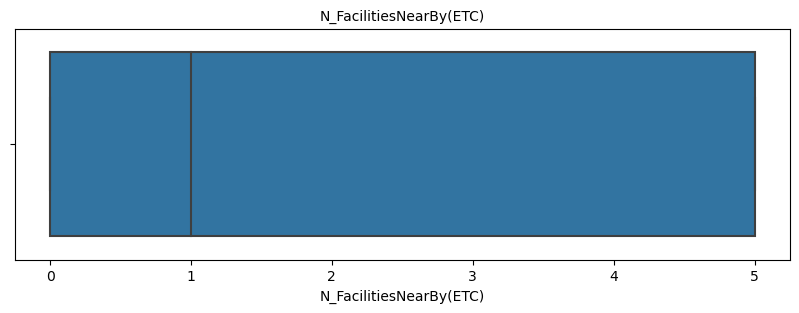

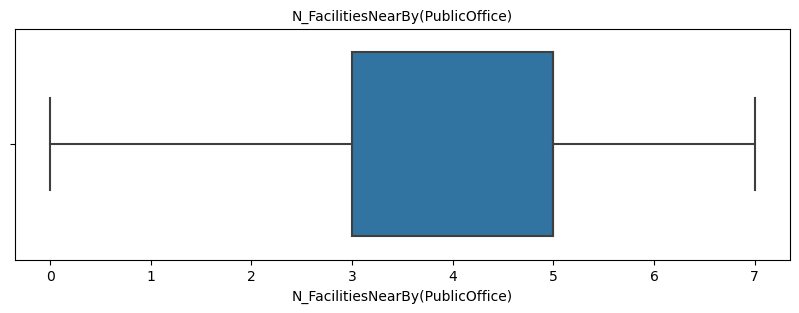

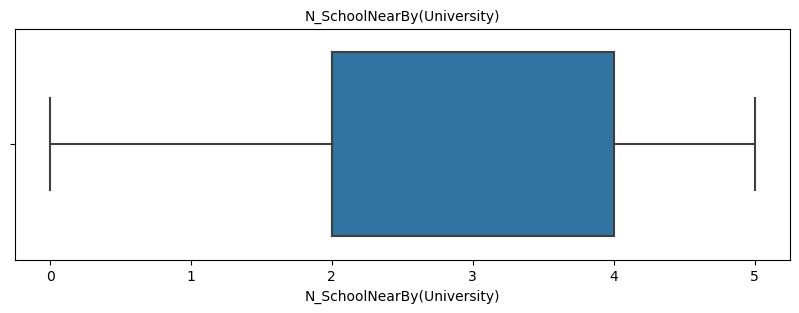

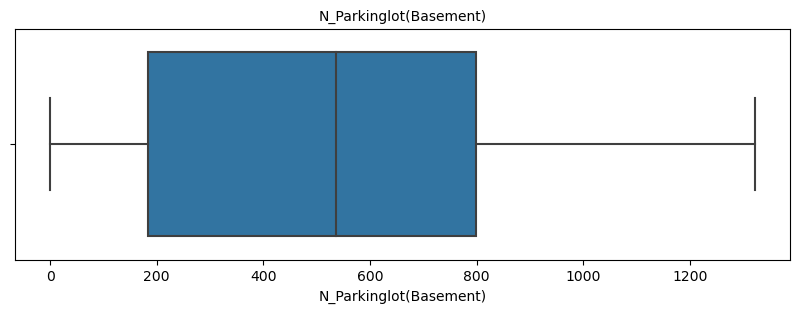

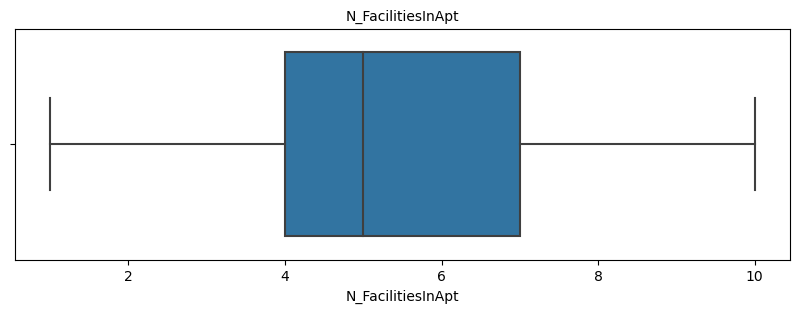

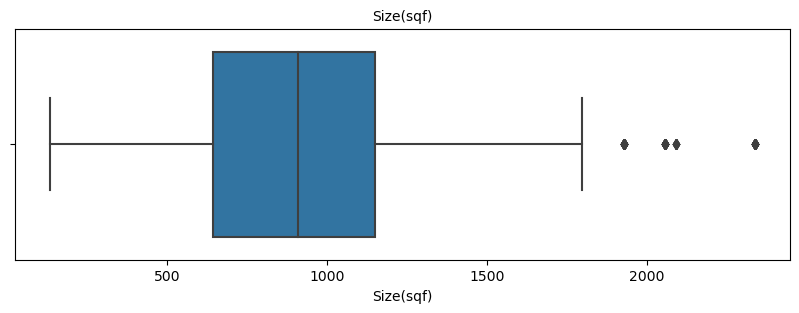

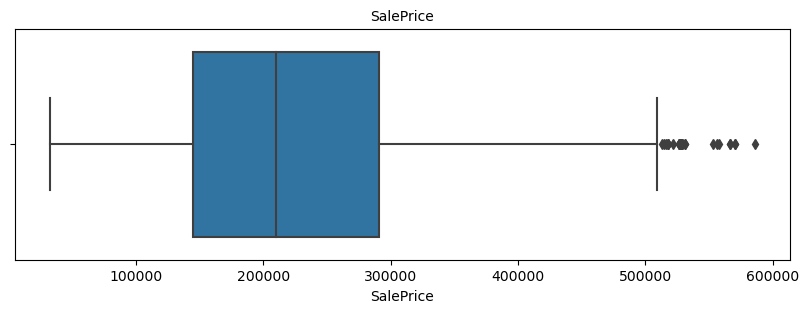

In [16]:
# visualisasi boxplot
for feature in numerik:
    vis_boxplot(df,feature)

Dari 7 variabel numerik, hanya 2 variabel yang memiliki outlier, yaitu variabel `SalePrice` dan `Size(sqf)` dengan proporsi outlier yang relatif kecil (2%, 0.6%). 

Hasil visualisasi boxplot pada variabel `Size(sqf)` dapat dilihat bahwa variabel tersebut hanya memiliki outlier yang nilai besar karena lebih besar dari batas atas serta terdapat global outlier. Hal tersebut dapat diartikan bahwa data yang termasuk outlier pada variabel ini bisa dianggap apartemen yang sangat luas **berdasarkan dataset ini**

Hasil visualisasi boxplot pada variabel `SalePrice` dapat dilihat bahwa variabel tersebut hanya memiliki outlier yang nilai besar karena lebih besar dari batas atas serta outlier yang dimiliki cenderung berkumpul. Hal tersebut dapat diartikan bahwa data yang termasuk outlier pada variabel ini bisa dianggap apartemen yang sangat mahal **berdasarkan dataset ini**

In [17]:
# mencoba melihat outlier berdasarkan batas atas yang telah dicari sebelumnya

df_outlier_price = df[df['SalePrice'] > 510747.0]
df_outlier_size = df[df['Size(sqf)'] > 1906.5]
df_outlier_both = df[(df['Size(sqf)'] > 1906.5) & (df['SalePrice'] > 510747.0)]

display(df_outlier_price.sort_values('Size(sqf)', ascending = True),
        df_outlier_size,
        df_outlier_both)

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
3502,terraced,0-5min,Myung-duk,5.0,7.0,5.0,1174.0,2014,9,1085,515044
2100,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1519,530973
1295,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1519,526548
204,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,566371
3939,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,513274
3966,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,529203
1998,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,526548
1877,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,515929
2015,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,517699
1180,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1643,530973


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
106,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,2337,243362
134,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,2056,424778
207,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,348283
234,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,566371
288,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,2092,300884
...,...,...,...,...,...,...,...,...,...,...,...
3949,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,556637
3977,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,383716
4027,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,2337,193805
4074,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,2337,254424


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
234,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,566371
549,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,553097
550,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,570796
656,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,528318
669,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,517699
971,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,529203
1895,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,522123
1982,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,517699
2128,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,585840
2363,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1928,527433


In [18]:
df_outlier_size['SubwayStation'].value_counts()

Kyungbuk_uni_hospital    42
Myung-duk                29
Sin-nam                  27
Name: SubwayStation, dtype: int64

In [19]:
df_outlier_size['TimeToSubway'].value_counts()

0-5min         61
15min~20min    29
10min~15min     8
Name: TimeToSubway, dtype: int64

In [20]:
df_outlier_size['HallwayType'].value_counts()

terraced    69
mixed       29
Name: HallwayType, dtype: int64

Proses analisis outlier dilakukan dengan 3 cara:
1. Melihat baris data yang nilai pada variabel `SalePrice` lebih dari batas atas
1. Melihat baris data yang nilai pada variabel `Size(sqf)` lebih dari batas atas
1. Melihat baris data yang nilai pada variabel `SalePrice` dan variabel `Size(sqf)` lebih dari batas atas 

Berikut merupakan insight yang didapat:
1. Kebanyakan apartemen yang sangat mahal beripe terraced, sangat dekat dengan stasiun Kyungbuk_uni_hospital, memiliki banyak tempat pakir, dan apartemen dibangun pada tahun 2007.
1. 	Kebanyakan apartemen yang sangat luas bertipe terraced dan disekitar daerahnya terdapat stasiun.
1. Terdapat apartemen yang memiliki nilai pada variabel `Size(sqf)` lebih kecil dibandingkan batas atas variabel tersebut namun nilai pada variabel `SalePrice` lebih besar dibandingkan batas atas variabel tersebut. Hal tersebut bisa dianggap seperti apartemen memiliki ukuran yang relatif kecil namun harga yang mahal (overprice). 
1. Apartemen yang sangat luas dan sangat mahal memiliki nilai karakteristik yang sama, sehingga bisa dianggap bahwa apartemen tersebut terletak pada daerah atau gedung yang sama.
1. Oleh karena itu nilai outlier yang terdeteksi cenderung disebabkan karena memang ada nilai yang disebabkan oleh kondisi yang ada, bukan karena experimental error.

In [21]:
rekap = pd.DataFrame()
kolom = []
pval = []
hasil = []
angka = 0


for i in df[numerik].columns:
    
    angka += 1
    kolom.append(i)

    dp_statistic, dp_pvalue = normaltest(df[i])

    if dp_pvalue > 0.05 :
        a = 'So, we assume a normal distribution'
        pval.append(dp_pvalue)
        hasil.append(a)
    else :
        b = 'So, we dont assume a normal distribution'
        pval.append(dp_pvalue)
        hasil.append(b)

    if angka == len(df[numerik].columns):
        rekap['Kolom'] = kolom
        rekap['Pval'] = pval
        rekap['Hasil'] = hasil

rekap   

,Kolom,Pval,Hasil
0,N_FacilitiesNearBy(ETC),0.000000e+00,"So, we dont assume a normal distribution"
1,N_FacilitiesNearBy(PublicOffice),4.080101e-135,"So, we dont assume a normal distribution"
2,N_SchoolNearBy(University),0.000000e+00,"So, we dont assume a normal distribution"
3,N_Parkinglot(Basement),1.054470e-182,"So, we dont assume a normal distribution"
4,N_FacilitiesInApt,2.876296e-135,"So, we dont assume a normal distribution"
5,Size(sqf),1.106320e-101,"So, we dont assume a normal distribution"
6,SalePrice,3.212361e-35,"So, we dont assume a normal distribution"


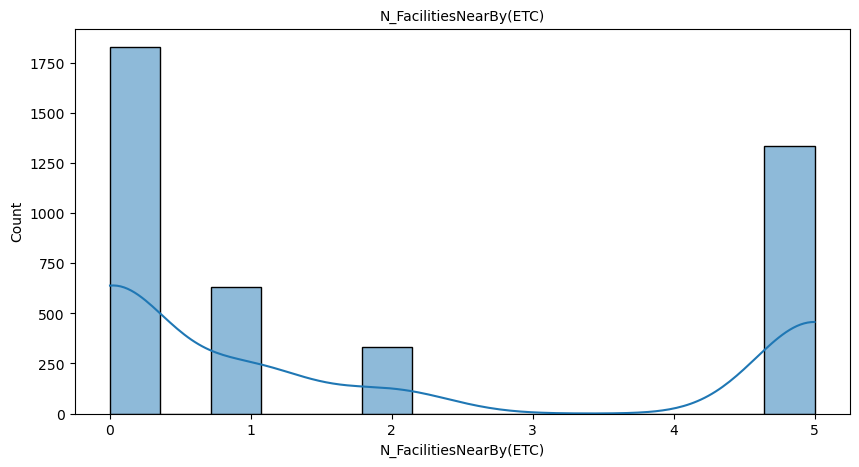

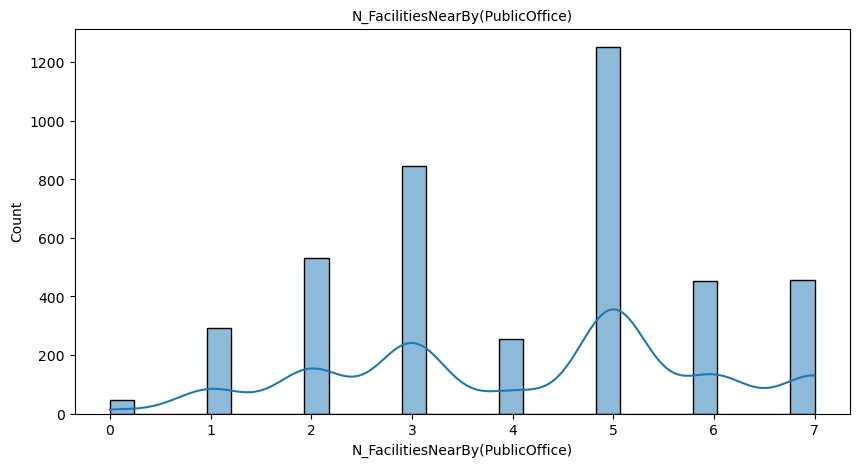

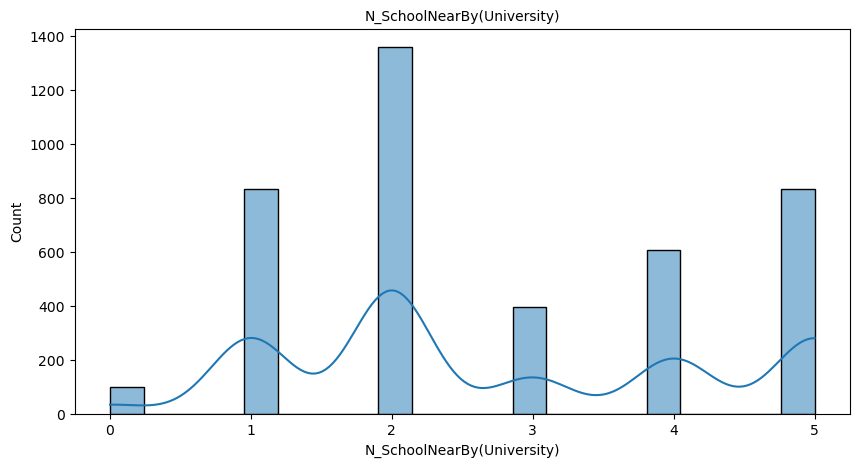

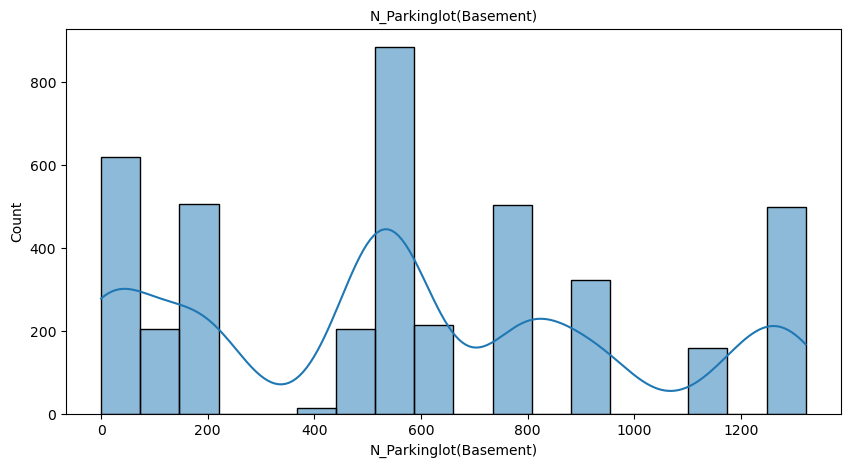

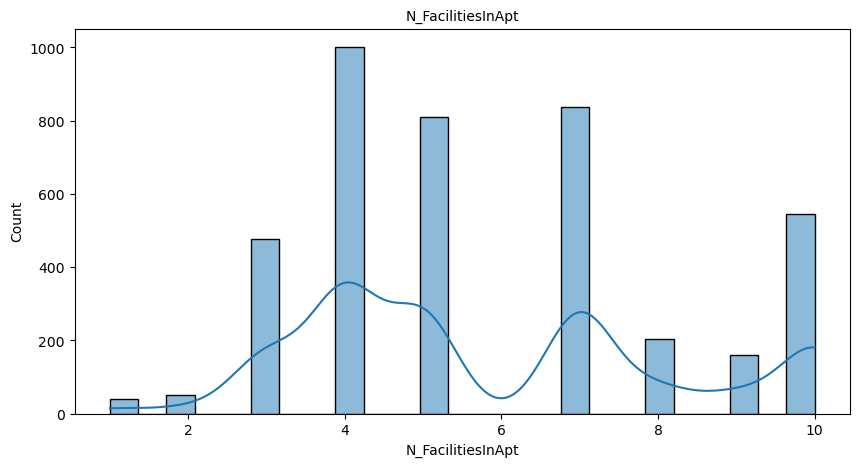

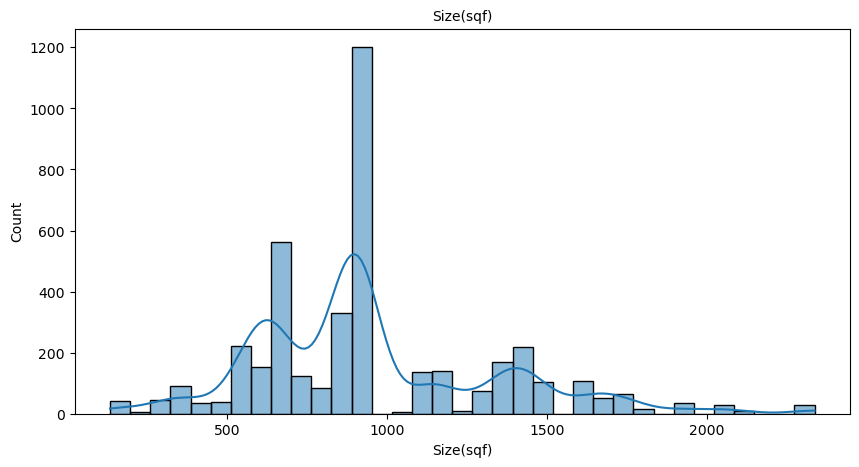

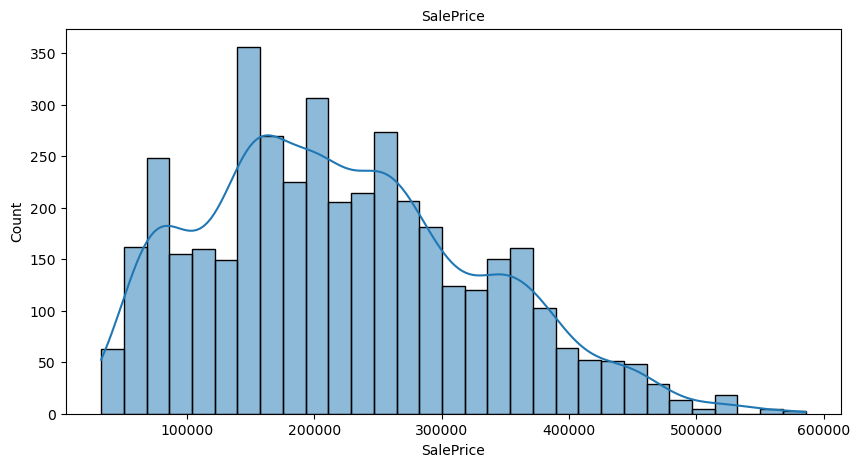

In [22]:
# visualisasi histogram
for feature in numerik:
    vis_hist(df,feature)

Dari hasil pengecekan distribusi menggunakan normaltest serta visualisasi dengan histogram  dapat dilihat bahwa untuk setiap variabel numerikal tidak berdistribusi normal

Dapat dilihat untuk histogram target (`SalePrice`) membentuk right skewed distribution atau positive skewed, hal tersebut dapat didukung karena adanya temuan outlier pada variabel tersebut, dimana outlier tersebut menunjukan bahwa terdapat apartemen yang harganya sangat mahal. Selain dari itu, sebaran nilai dari variabel target memiliki ragam atau rentang yang besar, sehingga cocok mengunakan metrik evaluasi MSLE

In [23]:
# pengecekan missing value
df.isna().sum()

HallwayType                         0
TimeToSubway                        0
SubwayStation                       0
N_FacilitiesNearBy(ETC)             0
N_FacilitiesNearBy(PublicOffice)    0
N_SchoolNearBy(University)          0
N_Parkinglot(Basement)              0
YearBuilt                           0
N_FacilitiesInApt                   0
Size(sqf)                           0
SalePrice                           0
dtype: int64

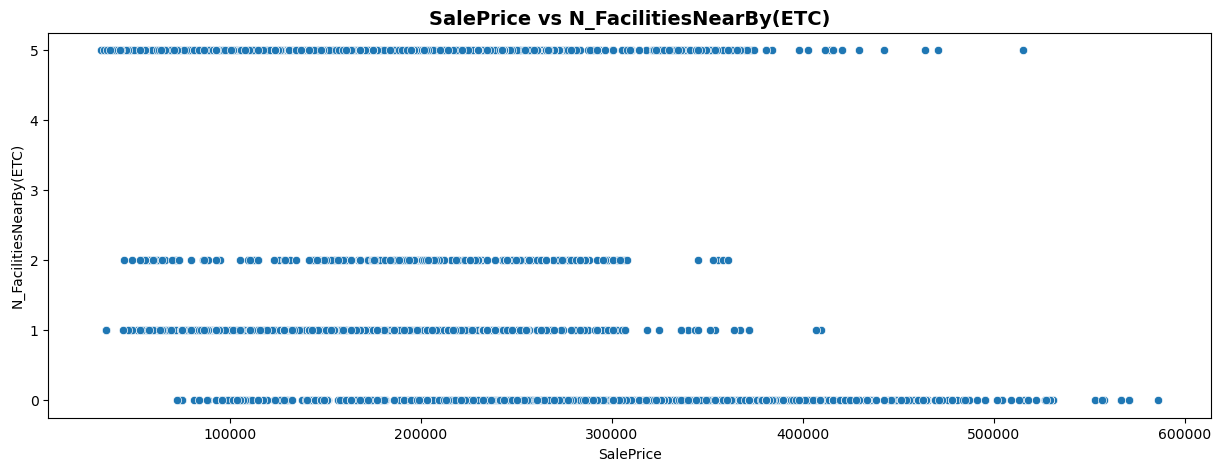

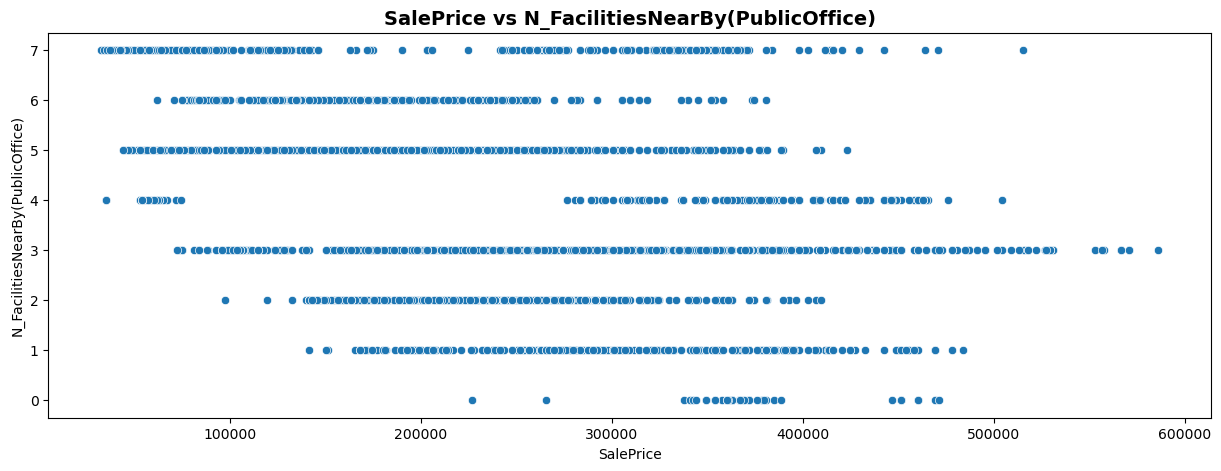

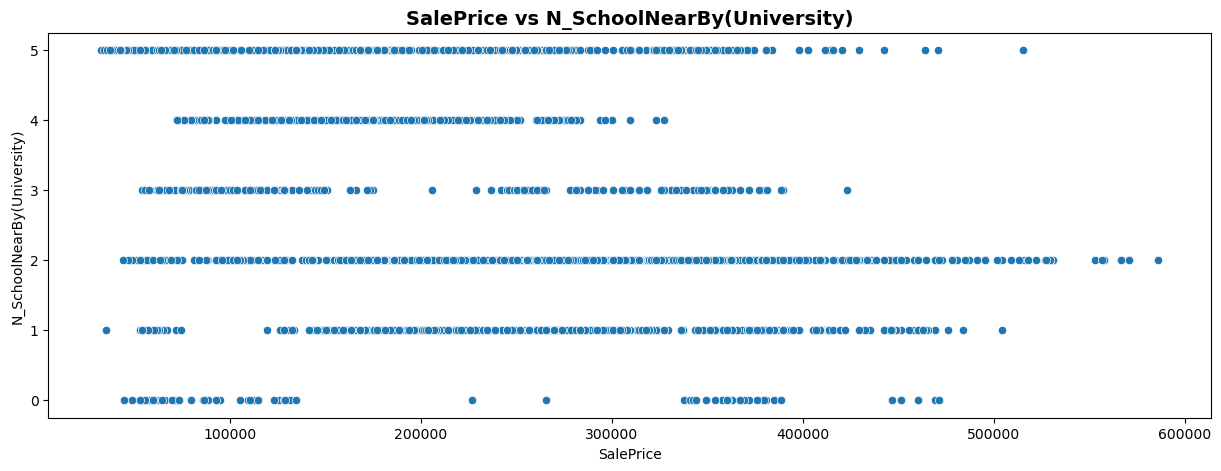

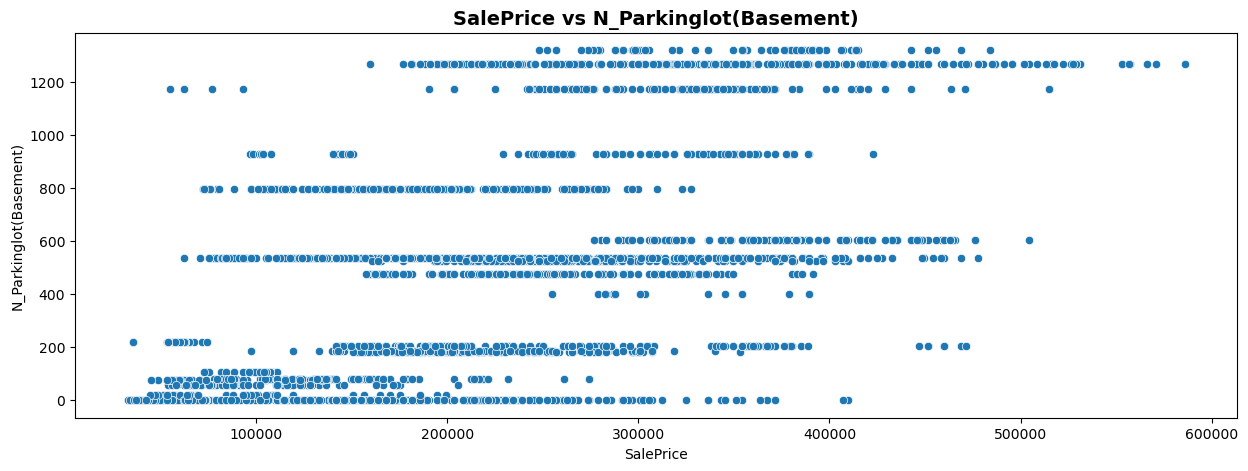

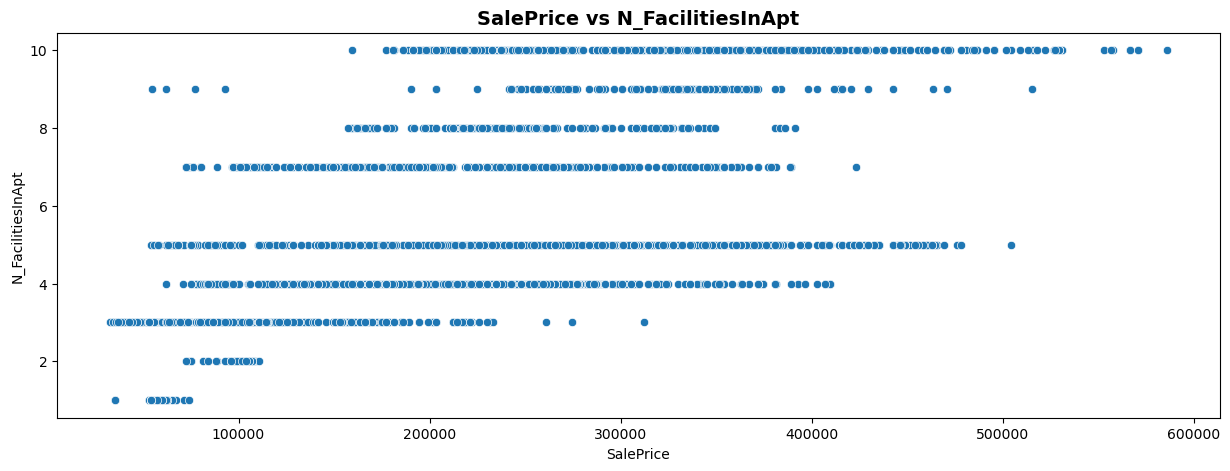

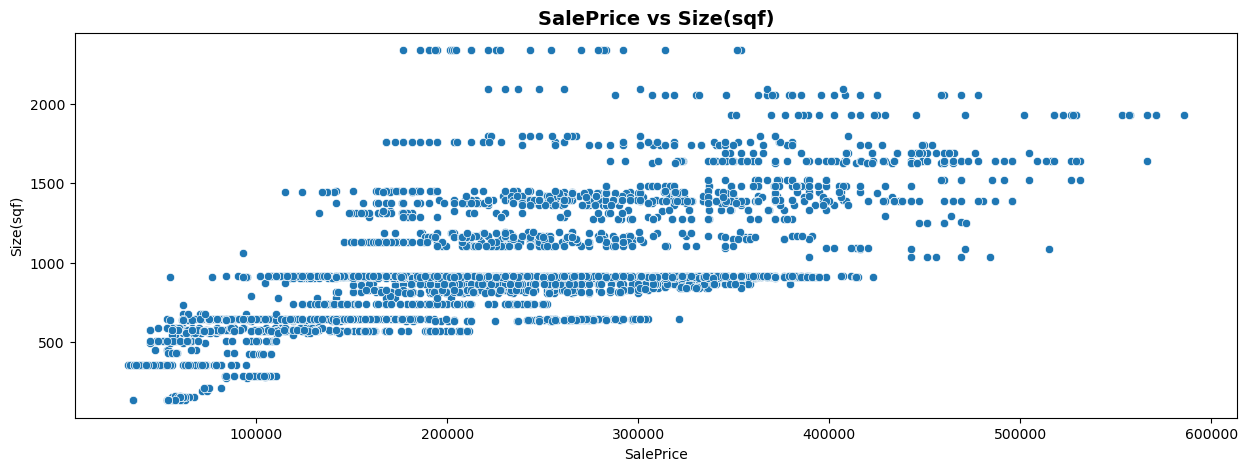

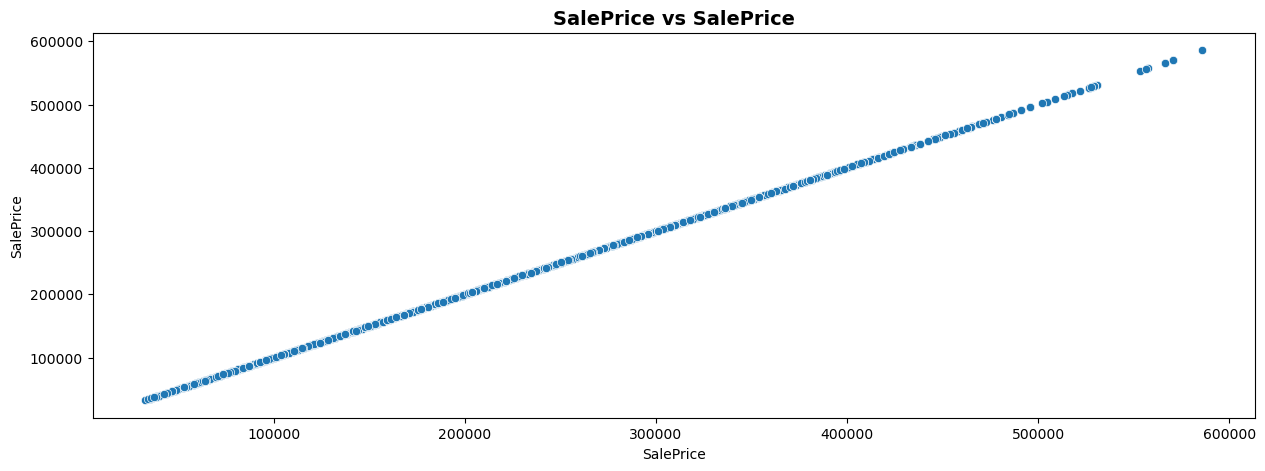

In [24]:
# visualsisasi scatter plot antar fitur dengan target
for fitur in df[numerik].columns:
    scatt(df, 'SalePrice', fitur)

C:\Users\fadhl\AppData\Local\Temp\ipykernel_46472\764133453.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='spearman'), cmap="YlGnBu", annot=True, square=True, vmin=-1, linewidth=.5)


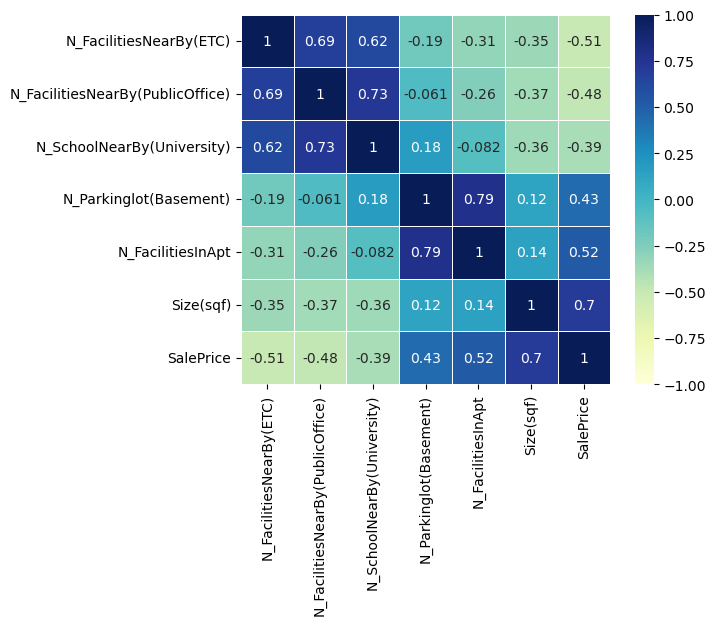

In [25]:
# cek korelasi antar target dengan fitur
sns.heatmap(df.corr(method='spearman'), cmap="YlGnBu", annot=True, square=True, vmin=-1, linewidth=.5)
plt.show()

Koefisien korelasi:
- 0 - 0.3 -> week
- 0.3 - 0.7 -> medium
- 0.7 - 1 -> strong

sumber : video e-learning

1. Korelasi target (`SalePrice`) dengan fitur
<br>
    - `SalePrice` dengan `N_FacilitiesNearBy(ETC)` memiliki nilai korelasi sebesar 0.51 (Negative direction)
    - `SalePrice` dengan `N_FacilitiesNearBy(PublicOffice)` memiliki nilai korelasi sebesar 0.48 (Negative direction)
    - `SalePrice` dengan `N_SchoolNearBy(University)` memiliki nilai korelasi sebesar 0.39 (Negative direction)
    - `SalePrice` dengan `N_Parkinglot(Basement)` memiliki nilai korelasi sebesar 0.43 (Positive direction)
    - `SalePrice` dengan `N_FacilitiesInApt` memiliki nilai korelasi sebesar  0.52 (Positive direction)
    - `SalePrice` dengan `Size(sqf)` memiliki nilai korelasi sebesar  0.7 (Positive direction)

Fitur `Size(sqf)` merupakan satu-satunya fitur yang memiliki korelasi  kuat terhadap `SalePrice`

C:\Users\fadhl\AppData\Local\Temp\ipykernel_46472\4137199657.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop('SalePrice', axis = 1).corr(method='spearman'), cmap="YlGnBu", annot=True, square=True, vmin=-1, linewidth=.5)


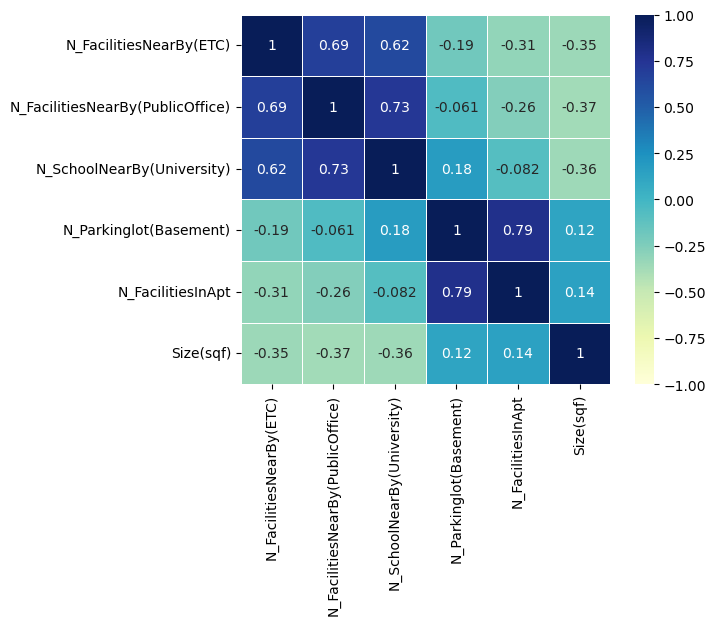

In [26]:
# cek korelasi antar fitur
sns.heatmap(df.drop('SalePrice', axis = 1).corr(method='spearman'), cmap="YlGnBu", annot=True, square=True, vmin=-1, linewidth=.5)
plt.show()

Pengecekan korelasi antar fitur dilakukan untuk melihat apakah adanya fenomena multikolinearitas. Multikolinearitas merupakan fenomena apabila terdapat hubungan korelasi yang kuat antar independen variabel [(Sushmitha, 2020)](https://towardsdatascience.com/how-to-detect-and-deal-with-multicollinearity-9e02b18695f1). Koefisien korelasi antar variabel independen dengan nilai >  0.7 dapat mengindikasikan terdapat multikolinearitas [(Rekha, 2019)](https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a). Berdasarakan hal tersebut dapat dilihat bahwa terdapat beberapa fitur yang mengalami multikolinearitas, fitur tersebut dapat dilihat sebagai berikut:
- `N_FacilitiesNearBy(PublicOffice)` dan `N_FacilitiesNearBy(ETC)` -> 0.69 ~ 0.7
- `N_SchoolNearBy(University)` dan `N_FacilitiesNearBy(PublicOffice)` -> 0.73
- `N_FacilitiesInApt` dan `N_Parkinglot(Basement)` -> 0.79

Selain dengan koefisien korelasi, pengecekan multikolinearitas juga dapat dilihat dari nilai VIF. Nilai VIF > 10 menandakan adanya masalah multikolinearitas yang serius.

In [27]:
# pengecekan nilai VIF
cek_vif = df[numerik].drop(['SalePrice'], axis=1)

In [28]:
vif(cek_vif).sort_values('vif', ascending=False)

,variabel,vif
2,N_SchoolNearBy(University),16.836527
4,N_FacilitiesInApt,16.028845
1,N_FacilitiesNearBy(PublicOffice),12.969386
3,N_Parkinglot(Basement),9.435882
0,N_FacilitiesNearBy(ETC),5.258321
5,Size(sqf),5.211340


Dapat dilihat berdasarkan hasil nilai VIF, variabel `N_SchoolNearBy(University)`, `N_FacilitiesInApt`, dan `N_FacilitiesNearBy(PublicOffice)` memiliki nilai VIF > dari 10, sehingga terindikasi adanya masalah multikolinearitas yang serius. Sehingga akan perlu ditanggulangi pada tahap data preparation.

# Data Preparation

In [29]:
# membuat variabel baru dari hasil copy variabel df, untuk menjadi variabel yang disiapkan
df_prep = df.copy()
df_prep

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


## 1. Handling Outlier

Sesuai temuan pada data understanding, bahwa hanya 2 variabel yang memiliki outlier. Apabila outlier dibuang masih realistis karena jumlahnya yang relatif sedikit, sehingga tidak banyak informasi yang dibuang. Namun, seperti yang diketahui sebelumnya bahwa outlier tersebut disebabkan oleh kondisi yang ada, sehingga nilai tersebut masih realistis. Oleh karena itu pada kasus ini outlier tidak akan dibuang.

## 2. Feature Selection

Berdasarkan hasil koefisien korelasi serta nilai VIF terdapat temuan multikolinearitas pada variabel `N_Parkinglot(Basement)`, `N_FacilitiesNearBy(ETC)`,  `N_SchoolNearBy(University)`, `N_FacilitiesInApt`, dan `N_FacilitiesNearBy(PublicOffice)`.

Mencoba menganalisis hubungan antar fitur berdasarkan domain knowledge serta deskripsi dataset:
1. `N_SchoolNearBy(University)` memliki deskripsi banyaknya universitas di sekitar apartemen, umumnya di universitas terdapat fasilitas umum seperti bank atau ATM, puskesmas atau klinik, sarana olahraga, dimana fasilitas tersebut juga biasanya dapat digunakan oleh warga sekitar, oleh karena itu bisa saja nilai dari variabel `N_FacilitiesNearBy(PublicOffice)` atau `N_FacilitiesNearBy(ETC)` meningkat juga apabila banyak universitas di sekitar apartemen.
1. `N_Parkinglot(Basement)` memiliki deskripsi banyaknya tempat parkir, sehingga dapat diartikan sebagai fasilitas apartemen, oleh karena itu bisa saja nilai dari variabel `N_FacilitiesInApt` meningkat juga karena tempat parkir merupakan salah satu fasilitas dari apartemen.
1. `N_FacilitiesNearBy(ETC)` memiliki deskripsi banyaknya fasilitas di sekitar apertemen, universitas merupakan salah satu jenis **fasilitas pendidikan**, sehingga bisa saja apabila banyak universitas (`N_SchoolNearBy(University)` bernilai tinggi) maka akan mempengaruhi juga nilai pada varaibel `N_FacilitiesNearBy(ETC)`

Oleh karena itu pada kasus ini akan dicoba membuang fitur yang dapat digambarkan oleh fitur lain berdasarkan domain knowledge, kemudian menghitung nilai VIF yang ada.

In [30]:
cek_vif.head(3)

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),N_FacilitiesInApt,Size(sqf)
0,0.0,3.0,2.0,1270.0,10,1387
1,1.0,5.0,1.0,0.0,4,914
2,1.0,7.0,3.0,56.0,5,558


In [31]:
# mencoba membuang variabel `N_Parkinglot(Basement)` 
vif(cek_vif.drop(['N_Parkinglot(Basement)'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
2,N_SchoolNearBy(University),15.165116
1,N_FacilitiesNearBy(PublicOffice),11.538953
3,N_FacilitiesInApt,5.761597
0,N_FacilitiesNearBy(ETC),5.207005
4,Size(sqf),5.122661


Masih terdapat nilai VIF > 10

In [32]:
# mencoba membuang variabel `N_Parkinglot(Basement)`, `N_FacilitiesNearBy(PublicOffice)`
vif(cek_vif.drop(['N_Parkinglot(Basement)','N_FacilitiesNearBy(PublicOffice)'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
1,N_SchoolNearBy(University),10.027453
2,N_FacilitiesInApt,5.708161
0,N_FacilitiesNearBy(ETC),5.096089
3,Size(sqf),4.734995


Masih terdapat nilai VIF > 10

In [33]:
# mencoba membuang variabel `N_Parkinglot(Basement)`, `N_FacilitiesNearBy(PublicOffice)`, `N_SchoolNearBy(University)`
vif(cek_vif.drop(['N_Parkinglot(Basement)','N_FacilitiesNearBy(PublicOffice)','N_SchoolNearBy(University)'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
1,N_FacilitiesInApt,4.707423
2,Size(sqf),4.456734
0,N_FacilitiesNearBy(ETC),1.467994


Berdasarkan hasil pengecekan VIF saat membuang variabel `N_Parkinglot(Basement)`, `N_FacilitiesNearBy(PublicOffice)` dan `N_SchoolNearBy(University)` nilai VIF menjadi relatif kecil, sehingga tidak terdapat masalah multikolinearitas yang serius.

In [34]:
# drop variabel `N_Parkinglot(Basement)`, `N_FacilitiesNearBy(PublicOffice)`, `N_SchoolNearBy(University)`
df_prep.drop(['N_Parkinglot(Basement)','N_FacilitiesNearBy(PublicOffice)','N_SchoolNearBy(University)'], axis = 1, inplace = True)

In [35]:
df_prep.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,2006,5,1743,311504


## 3. Encoding

In [36]:
ordinal = [
    {'col':'TimeToSubway',
    'mapping':{'no_bus_stop_nearby' : 0,
    '0-5min' : 1,
    '10min~15min' : 2,
    '15min~20min' : 3,
    }},
    
    {'col':'YearBuilt',
    'mapping':{'1978' : 0,
    '1980' : 1,
    '1985' : 2,
    '1986' : 3,
    '1992' : 4,
    '1993' : 5,
    '1997' : 6,
    '2003' : 7,
    '2005' : 8,
    '2006' : 9,
    '2007' : 10,
    '2008' : 11,
    '2009' : 12,
    '2013' : 13,
    '2014' : 14,
    '2015' : 15,
    }},
]

In [37]:
ohe = OneHotEncoder(drop='first')
ohe_var = ['HallwayType','SubwayStation']

ordinal_var = ['TimeToSubway','YearBuilt']

transformer = ColumnTransformer([
    ('ohe', ohe, ohe_var),
    ('ordinal',ce.OrdinalEncoder(mapping= ordinal), ordinal_var)
], remainder='passthrough')

## 4. Split Data

In [38]:
X = df_prep.drop('SalePrice', axis=1)
y = df_prep['SalePrice']

display(X,y)

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf)
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1387
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914
2,mixed,15min~20min,Chil-sung-market,1.0,1997,5,558
3,mixed,5min~10min,Bangoge,5.0,2005,7,914
4,terraced,0-5min,Sin-nam,0.0,2006,5,1743
...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,2008,8,914
4119,mixed,15min~20min,Myung-duk,5.0,1993,4,1451
4120,mixed,15min~20min,Myung-duk,5.0,1993,4,1761
4121,corridor,5min~10min,Daegu,2.0,1985,3,676


0       346017
1       150442
2        61946
3       165486
4       311504
         ...  
4118    323008
4119    242477
4120    168141
4121     73451
4122    250442
Name: SalePrice, Length: 4123, dtype: int64

In [39]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

display(X_trainval,
        X_test,
        y_trainval,
        y_test)

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf)
1146,mixed,15min~20min,Myung-duk,5.0,1993,4,2337
2984,terraced,0-5min,Banwoldang,0.0,2007,5,1334
3889,mixed,15min~20min,Myung-duk,5.0,1993,4,914
2825,terraced,5min~10min,no_subway_nearby,0.0,2015,10,644
1921,terraced,0-5min,Sin-nam,0.0,2008,8,829
...,...,...,...,...,...,...,...
3444,corridor,5min~10min,Banwoldang,0.0,2014,2,213
466,corridor,5min~10min,Banwoldang,0.0,2014,2,288
3092,mixed,5min~10min,Bangoge,5.0,2005,7,914
3772,mixed,15min~20min,Myung-duk,5.0,1993,4,1288


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf)
1618,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2013,7,910
893,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914
309,corridor,5min~10min,Daegu,2.0,1985,3,676
1877,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1643
1189,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,1131
...,...,...,...,...,...,...,...
479,mixed,5min~10min,Bangoge,5.0,2005,7,914
3981,mixed,5min~10min,Bangoge,5.0,2005,7,572
1592,mixed,15min~20min,Myung-duk,1.0,1992,3,644
838,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,2006,5,910


1146    212389
2984    357522
3889    172566
2825    287610
1921    252212
         ...  
3444     74955
466     104424
3092    263716
3772    181415
860     201769
Name: SalePrice, Length: 3298, dtype: int64

1618    255442
893     184955
309      70796
1877    515929
1189    150442
         ...  
479     173451
3981    107964
1592     82300
838     181415
1891    144752
Name: SalePrice, Length: 825, dtype: int64

# Data Analysis

Setelah data dibersihkan pada tahap data preparation, maka data siap untuk dianalisis

In [40]:
df_prep

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,1985,3,676,73451


In [41]:
group1 = pd.DataFrame(df_prep.groupby(['HallwayType','TimeToSubway','YearBuilt','SubwayStation'])['SubwayStation'].count())
group1.rename(columns={'SubwayStation': 'Jumlah'},inplace=True)
group1

Jumlah
HallwayType TimeToSubway       YearBuilt SubwayStation                
corridor    0-5min             1978      Kyungbuk_uni_hospital      49
            10min~15min        1992      Myung-duk                 222
            5min~10min         1985      Daegu                      51
                               1986      Sin-nam                    51
                               2014      Banwoldang                 50
                                         no_subway_nearby           41
mixed       15min~20min        1992      Myung-duk                 104
                               1993      Myung-duk                 451
                               1997      Chil-sung-market           67
                               2003      Chil-sung-market            7
            5min~10min         2005      Bangoge                   502
terraced    0-5min             1980      Myung-duk                   4
                               2006      Myung-duk                 108
                                         Sin-nam                   213
                               2007      Banwoldang                433
                                         Kyungbuk_uni_hospital     420
                               2008      Sin-nam                   203
                               2013      Kyungbuk_uni_hospital     322
                               2014      Banwoldang                 46
                                         Myung-duk                 155
            10min~15min        1986      Kyungbuk_uni_hospital     222
                               2006      Kyungbuk_uni_hospital     139
            5min~10min         2015      Daegu                      14
                                         no_subway_nearby           78
            no_bus_stop_nearby 2009      no_subway_nearby          171

In [42]:
group1_reset = group1.reset_index()
group1_reset.head(10)

,HallwayType,TimeToSubway,YearBuilt,SubwayStation,Jumlah
0,corridor,0-5min,1978,Kyungbuk_uni_hospital,49
1,corridor,10min~15min,1992,Myung-duk,222
2,corridor,5min~10min,1985,Daegu,51
3,corridor,5min~10min,1986,Sin-nam,51
4,corridor,5min~10min,2014,Banwoldang,50
5,corridor,5min~10min,2014,no_subway_nearby,41
6,mixed,15min~20min,1992,Myung-duk,104
7,mixed,15min~20min,1993,Myung-duk,451
8,mixed,15min~20min,1997,Chil-sung-market,67
9,mixed,15min~20min,2003,Chil-sung-market,7


In [43]:
fig = px.sunburst(group1_reset, 
                  path=['HallwayType', 'TimeToSubway', 'YearBuilt', 'SubwayStation'], 
                  values='Jumlah')


fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)

fig.show()

c:\Users\fadhl\anaconda3\lib\site-packages\plotly\express\_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
c:\Users\fadhl\anaconda3\lib\site-packages\plotly\express\_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
c:\Users\fadhl\anaconda3\lib\site-packages\plotly\express\_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
c:\Users\fadhl\anaconda3\lib\site-packages\plotly\express\_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [44]:
group2 = df_prep.groupby('HallwayType', as_index=False)[['SalePrice','Size(sqf)','N_FacilitiesNearBy(ETC)','N_FacilitiesInApt']].median()
group2

,HallwayType,SalePrice,Size(sqf),N_FacilitiesNearBy(ETC),N_FacilitiesInApt
0,corridor,74557.0,576.0,2.0,3.0
1,mixed,153539.0,743.0,5.0,5.0
2,terraced,264601.0,914.0,0.0,5.0


Text(0.5, 1.0, 'Harga Median Setiap Tipe Apartemen')

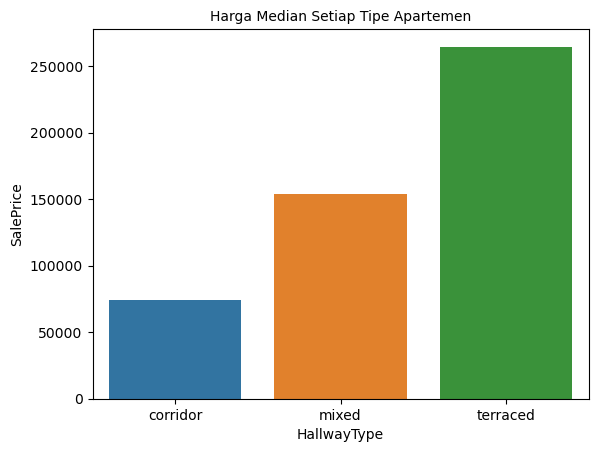

In [45]:
sns.barplot(data= group2, x='HallwayType', y='SalePrice').set_title('Harga Median Setiap Tipe Apartemen', fontsize=10)

Text(0.5, 1.0, 'Luas Median Setiap Tipe Apartemen')

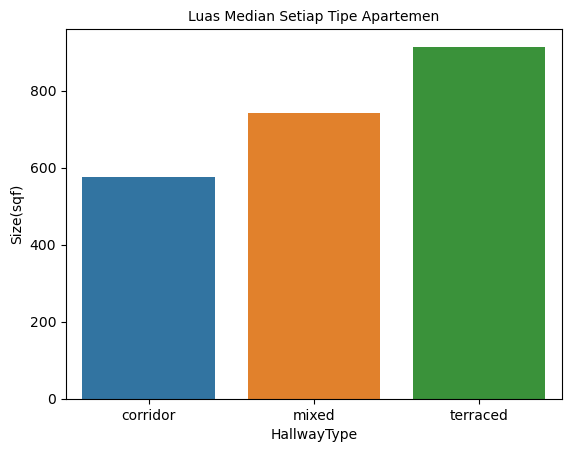

In [46]:
sns.barplot(data= group2, x='HallwayType', y='Size(sqf)').set_title('Luas Median Setiap Tipe Apartemen', fontsize=10)

# Modeling & Evaluation

## Model Benchmark 1
Mencari model benchmark dengan cara melakukan pemodelan menggunakan beberapa algoritma dengan menggunakan gridsearchcv.

- linreg, lasso dan ridge model regresi linear
- knn, model berdasarkan distance based
- tree based:
    - decision tree
    - random forest (ensemble)
    - gradient dan extream gradient (boosting)
- svr, model regresi linear berdasarkan hyperlane dengan melihat jarak margin [(Alakh, 2020)](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/#:~:text=A.,line%20to%20the%20data%20points.)

In [47]:
linreg = LinearRegression()
lasso = Lasso()
ridge = Ridge()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
svr = SVR()

In [48]:
estimator = Pipeline([
    ('prep', transformer),
    ('reg',linreg) # linreg menjadi default
])

hyperparam_space = {
    'reg': [lasso, ridge, knn, dt, rf, gb, xgb, svr]
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

grid_model = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_log_error'],
    refit= 'neg_mean_squared_log_error', 
    n_jobs=-1, 
)

#  dalam kasus ini metrik yang digunakan pada parameter refit adalah MSLE karena variabel target memiliki ragam yang besar

In [49]:
grid_model.fit(X_trainval, y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['HallwayType',
                                                                          'SubwayStation']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
1...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...),
                                 SVR()]},
             refit='neg_mean_squared_log_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_log_error'])

In [50]:
hasil_grid = pd.DataFrame(grid_model.cv_results_)

display(hasil_grid[['param_reg',
                    'mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error',
                    'mean_test_neg_mean_absolute_percentage_error','std_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error',
                    'mean_test_neg_mean_squared_log_error','std_test_neg_mean_squared_log_error','rank_test_neg_mean_squared_log_error']],
        grid_model.best_params_, 
        grid_model.best_score_)

,param_reg,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error
0,Lasso(),-42491.620117,498.359267,6,-0.232093,0.004257,6,-0.074029,0.004351,7
1,Ridge(),-42494.216839,499.780130,7,-0.232104,0.004241,7,-0.073981,0.004318,6
2,KNeighborsRegressor(),-36973.435267,891.727942,5,-0.199082,0.009952,5,-0.061042,0.002240,5
3,DecisionTreeRegressor(random_state=42),-34706.236181,379.812708,3,-0.185592,0.004528,3,-0.051695,0.002687,4
4,RandomForestRegressor(random_state=42),-34632.907422,338.290581,1,-0.185253,0.004046,2,-0.051452,0.001620,3
5,GradientBoostingRegressor(random_state=42),-34972.212296,504.115419,4,-0.187992,0.004953,4,-0.050827,0.001371,1
6,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=42, ...)",-34637.970216,327.570959,2,-0.184909,0.004022,1,-0.051223,0.001715,2
7,SVR(),-87423.693388,1175.783933,8,-0.579194,0.020711,8,-0.320194,0.011618,8


{'reg': GradientBoostingRegressor(random_state=42)}

-0.05082663270795349

Berdasarkan hasil di atas parameter terbaik berdasarkan MSLE adalah GradientBoostingRegressor untuk peringkat ke-1 dan XGBRegressor untuk peringkat ke-2, maka dari itu kedua algoritma ini dapat dibandingkan sebagai berikut:

- Dapat dilihat dari hasil bagian atas bahwa model GradientBoostingRegressor menjadi dengan peringkat ke-1 berdasarkan MSLE. GradientBoostingRegressor menduduki peringkat ke-4 pada metrik MAE dan MAPE.
- XGBRegressor menjadi peringkat ke-2 berdasarkan  MAE dan MSLE, selain dari itu menduduki peringkat ke-1 berdasarkan MAPE

## Model Benchmark 2 -> mentransformasi variabel target
Mencari model benchmark dengan cara melakukan pemodelan menggunakan beberapa algoritma dengan menggunakan gridsearchcv, namun target variabel melalui proses transformasi menggunakan `TransformedTargetRegressor()`. Berdasarkan dokumentasi [scikit learn](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py) mentransformasi variabel target dapat merubah distribusi mendekati normal serta dapat meningkatkan performansi model. Distribusi variabel target yang tidak normal dapat memberikan efek kepada performansi model, transformasi pada variabel target dapat menurunkan nilai metrik regresi sehingga dapat meningkatkan performansi model, selain itu transformasi pada variabel target memberikan efek yang berbeda untuk setiap algoritma yang digunakan [(Dimas, 2021).](https://medium.com/analytics-vidhya/effect-of-target-transformation-on-abalone-age-prediction-using-regression-model-da6d3a185a31)

In [51]:
log_lr = TransformedTargetRegressor(linreg, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_gb = TransformedTargetRegressor(gb, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_svr = TransformedTargetRegressor(svr, func=np.log, inverse_func=np.exp)

In [52]:
estimator = Pipeline([
    ('prep', transformer),
    ('reg',log_lr) 
])

hyperparam_space = {
    'reg': [log_lasso,log_ridge,log_knn,log_dt,log_rf,log_gb,log_xgb,log_svr]
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

grid_model_log = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_log_error'],
    refit= 'neg_mean_squared_log_error',
    n_jobs=-1, 
)

In [53]:
grid_model_log.fit(X_trainval,y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['HallwayType',
                                                                          'SubwayStation']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
1...
                                                                                   missing=nan,
                                                                                   monotone_constraints=None,
                                                                                   n_estimators=100,
                                                                                   n_jobs=None,
                                                                                   num_parallel_tree=None,
                                                                                   predictor=None,
                                                                                   random_state=42, ...)),
                                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                                            inverse_func=<ufunc 'exp'>,
                                                            regressor=SVR())]},
             refit='neg_mean_squared_log_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_log_error'])

In [54]:
hasil_grid_log = pd.DataFrame(grid_model_log.cv_results_)

display(hasil_grid_log[['param_reg',
                    'mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error','rank_test_neg_mean_absolute_error',
                    'mean_test_neg_mean_absolute_percentage_error','std_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error',
                    'mean_test_neg_mean_squared_log_error','std_test_neg_mean_squared_log_error','rank_test_neg_mean_squared_log_error']],
        grid_model_log.best_params_, 
        grid_model_log.best_score_)

,param_reg,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error,rank_test_neg_mean_squared_log_error
0,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=Lasso())",-65365.193369,2273.963971,8,-0.346836,0.009886,8,-0.162983,0.006375,8
1,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=Ridge())",-43186.127965,1327.796484,6,-0.226368,0.005749,6,-0.074837,0.004317,6
2,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=KNeighborsRegressor())",-36523.501559,887.952930,5,-0.191414,0.008384,5,-0.059589,0.002544,5
3,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=DecisionTreeRegressor(random_state=42))",-33992.052186,251.265550,3,-0.174785,0.003902,2,-0.049287,0.001587,3
4,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=RandomForestRegressor(random_state=42))",-33987.096954,226.949662,2,-0.175046,0.003633,3,-0.049442,0.001346,4
5,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=GradientBoostingRegressor(random_state=42))",-34116.943160,394.289947,4,-0.175539,0.004554,4,-0.048897,0.002018,1
6,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=XGBRegressor(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None,\n early_stopping_rounds=None,\n enable_categorical=False,\n eval_metric=None,\n feature_types=None,\n gamma=None, gpu_id=None,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=None,\n max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None,\n max_depth=None,\n max_leaves=None,\n min_child_weight=None,\n missing=nan,\n monotone_constraints=None,\n n_estimators=100, n_jobs=None,\n num_parallel_tree=None,\n predictor=None,\n random_state=42, ...))",-33921.051018,325.801615,1,-0.174206,0.004537,1,-0.048995,0.001901,2
7,"TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,\n regressor=SVR())",-52540.902561,1233.405201,7,-0.274704,0.007359,7,-0.102556,0.003006,7


{'reg': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                            regressor=GradientBoostingRegressor(random_state=42))}

-0.048896878496947196

Berdasarkan hasil di atas parameter terbaik berdasarkan MSLE adalah GradientBoostingRegressor untuk peringkat ke-1 dan XGBRegressor untuk peringkat ke-2, mirip seperti sebelum menggunakan TranformedTargetRegressor. Perbandingan algoritma GradientBoostingRegressor dan XGBRegressor dapat dilihat sebagai berikut:

- Dapat dilihat dari bagian atas bahwa model GradientBoostingRegressor menjadi model terbaik berdasarkan MSLE. GradientBoostingRegressor hanya mengungguli pada metrik MSLE, sedangkan metrik MAE dan MAPE peringkat ke-4. 
- XGBRegressor menjadi peringkat ke-2 MSLE, selain dari itu menduduki peringkat ke-1 berdasarkan MAE dan MAPE



## Membandingkan Model Benchmark 1 dan 2

In [55]:
banding_model_benchmark = hasil_grid_log[(hasil_grid_log['rank_test_neg_mean_squared_log_error'] == 1) | (hasil_grid_log['rank_test_neg_mean_squared_log_error'] == 2)] 
banding_model_benchmark = banding_model_benchmark.append(hasil_grid[(hasil_grid['rank_test_neg_mean_squared_log_error'] == 1) | (hasil_grid['rank_test_neg_mean_squared_log_error'] == 2)]) 
banding_model_benchmark = banding_model_benchmark[['mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error',
                    'mean_test_neg_mean_absolute_percentage_error','std_test_neg_mean_absolute_percentage_error',
                    'mean_test_neg_mean_squared_log_error','std_test_neg_mean_squared_log_error']]
banding_model_benchmark.insert(loc=0, column='Model', value=['GB with TTR','XGB with TTR','GB','XGB'])
banding_model_benchmark.reset_index(drop='first', inplace = True)
banding_model_benchmark

C:\Users\fadhl\AppData\Local\Temp\ipykernel_46472\2756878389.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error
0,GB with TTR,-34116.943160,394.289947,-0.175539,0.004554,-0.048897,0.002018
1,XGB with TTR,-33921.051018,325.801615,-0.174206,0.004537,-0.048995,0.001901
2,GB,-34972.212296,504.115419,-0.187992,0.004953,-0.050827,0.001371
3,XGB,-34637.970216,327.570959,-0.184909,0.004022,-0.051223,0.001715


Berdasarkan tabel perbandingan di atas model yang mentransformasi target variabel memiliki nilai MSLE yang cenderung lebih kecil dibandingkan dengan model yang **tidak** mentransformasi target variabel. Oleh karena itu model yang dibandingkan adalah `GB with TTR` dan `XGB with TTR`	

In [56]:
banding_model_benchmark.loc[:1,:]

,Model,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_squared_log_error,std_test_neg_mean_squared_log_error
0,GB with TTR,-34116.943160,394.289947,-0.175539,0.004554,-0.048897,0.002018
1,XGB with TTR,-33921.051018,325.801615,-0.174206,0.004537,-0.048995,0.001901


Dapat dilihat bahwa `GB with TTR` hanya mengungguli pada metrik MSLE, sedangkan pada metrik MAE dan MAPE `XGB with TTR` lebih unggul. Nilai MSLE antara kedua algoritma tersebut memiliki selisih yang relatif kecil, namun nilai standar deviasi `XGB with TTR` memiliki nilai yang lebih kecil dibandingkan `GB with TTR`, standar deviasi yang kecil menandakan bahwa model tersebut lebih stabil. **Oleh karena itu model yang terpilih adalah `XGB with TTR`**

## Prediksi menggunakan data test 1
- XGBRegressor with TTR

In [57]:
xgb = XGBRegressor(random_state=42)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

model_log_xgb = Pipeline([
    ('preprocessing', transformer),
    ('model', log_xgb)
    ])

model_log_xgb.fit(X_trainval, y_trainval)
y_pred = model_log_xgb.predict(X_test)

hasil_pred = pd.DataFrame()
hasil_pred['Model'] = ['XGB with TTR']
hasil_pred['MAE'] = [mean_absolute_error(y_test, y_pred)]
hasil_pred['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred)]
hasil_pred['MSLE'] = [mean_squared_log_error(y_test, y_pred)]

display(hasil_pred, y_pred)


,Model,MAE,MAPE,MSLE
0,XGB with TTR,31603.71679,0.168463,0.04655


array([291988.25 , 168060.1  ,  77657.33 , 409529.72 , 194332.56 ,
       194332.56 , 149034.06 , 211694.48 ,  74431.69 , 222028.95 ,
       374934.62 , 100693.58 , 289293.56 , 213863.69 , 176612.89 ,
       251331.58 , 100693.58 , 237677.   , 210842.42 , 388730.16 ,
        52794.57 , 156535.72 , 149034.06 , 222028.95 ,  76003.88 ,
       203896.64 , 300007.2  , 269648.16 , 345121.47 , 329644.3  ,
       233994.81 , 149034.06 , 100487.625, 269648.16 , 345121.47 ,
        78815.44 , 285531.1  ,  81918.055, 251331.58 ,  94321.625,
       261384.11 , 149034.06 , 213863.69 , 328892.88 ,  84352.375,
       154736.67 , 100693.58 , 157226.64 , 223188.1  , 276991.75 ,
       156535.72 , 232221.03 , 281636.44 , 116041.82 , 100487.625,
       239743.36 , 261384.11 , 345121.47 , 457991.53 , 223188.1  ,
       194332.56 , 291988.25 , 261384.11 , 261384.11 , 203896.64 ,
       156535.72 , 116041.82 , 210842.42 , 288710.9  , 407643.78 ,
       168060.1  , 203896.64 , 176612.89 , 156535.72 , 334828.

## Hyperparameter tuning XGBRegressor

- Max depth, untuk menentukan kedalaman pohon
- N estimators, untuk menentukan banyaknya pohon yang dibuat
- Subsample, untuk menentukan rasio training model
- Gamma,untuk menentukan loss reduction
- Learning rate, untuk menentukan seberapa cepat model 'belajar'
- Random state, untuk mendapatakan hasil yang selalu sama

In [58]:
xgb = XGBRegressor(random_state=42)

estimator = Pipeline([
    ('prep', transformer),
    ('model',xgb) 
])

hyperparam_space = {
    'model__max_depth': [4,5,6,7,8], # default 6
    'model__n_estimators': [100,200], # default 100
    'model__subsample': [0.5,1], # default 1, 0.5 untuk mencegah overfitting
    'model__gamma': [0,2,4,6], # default 0
    'model__learning_rate': [0.3,0.5], # default 0.3
    'model__random_state': [42]
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

grid_model_tuning = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_log_error'],
    refit= 'neg_mean_squared_log_error',
    n_jobs=-1, 
)

In [59]:
grid_model_tuning.fit(X_trainval, y_trainval)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['HallwayType',
                                                                          'SubwayStation']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
1...
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 2, 4, 6],
                         'model__learning_rate': [0.3, 0.5],
                         'model__max_depth': [4, 5, 6, 7, 8],
                         'model__n_estimators': [100, 200],
                         'model__random_state': [42],
                         'model__subsample': [0.5, 1]},
             refit='neg_mean_squared_log_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_log_error'])

In [60]:
hasil_grid_tuning = pd.DataFrame(grid_model_tuning.cv_results_)

display(grid_model_tuning.best_params_, 
        grid_model_tuning.best_score_)

{'model__gamma': 0,
 'model__learning_rate': 0.3,
 'model__max_depth': 4,
 'model__n_estimators': 100,
 'model__random_state': 42,
 'model__subsample': 0.5}

-0.05040247722878864

## Prediksi menggunakan data test 2
1. XGBRegressor  Tuning with TTR

In [61]:
grid_model_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType',
                                                   'SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
15min~20min           3
dtype: int64},
                                                                          {'col': 'YearBuilt',
                                                                           'data_type': dtype('O'),
                                                                           'mappin...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [62]:
model_log_xgb_tuning = TransformedTargetRegressor(grid_model_tuning.best_estimator_,func=np.log, inverse_func=np.exp)

model_log_xgb_tuning.fit(X_trainval, y_trainval)
y_pred_tuning = model_log_xgb_tuning.predict(X_test)

hasil_pred_tuning = pd.DataFrame()
hasil_pred_tuning['Model'] = ['XGB  Tuning with TTR']
hasil_pred_tuning['MAE'] = [mean_absolute_error(y_test, y_pred_tuning)]
hasil_pred_tuning['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred_tuning)]
hasil_pred_tuning['MSLE'] = [mean_squared_log_error(y_test, y_pred_tuning)]

display(hasil_pred_tuning, y_pred_tuning)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331


array([292828.75 , 168524.23 ,  78025.09 , 404965.12 , 190106.03 ,
       190106.03 , 149969.62 , 206087.34 ,  74746.31 , 225188.84 ,
       372064.4  , 100150.66 , 288457.72 , 213774.78 , 175524.33 ,
       250727.1  , 100150.66 , 233393.98 , 212826.88 , 390869.9  ,
        52500.85 , 156662.22 , 149969.62 , 225188.84 ,  77466.87 ,
       202646.28 , 309659.2  , 271928.2  , 350188.47 , 326071.5  ,
       231541.69 , 149969.62 , 100238.28 , 271928.2  , 350188.47 ,
        78855.51 , 277935.62 ,  83918.05 , 250727.1  ,  94974.055,
       263874.44 , 149969.62 , 213774.78 , 339337.56 ,  81867.75 ,
       149001.5  , 100150.66 , 158983.52 , 222369.06 , 278197.1  ,
       156662.22 , 228067.22 , 277918.4  , 114177.625, 100238.28 ,
       240376.62 , 263874.44 , 350188.47 , 457261.4  , 222369.06 ,
       190106.03 , 292828.75 , 263874.44 , 263874.44 , 202646.28 ,
       156662.22 , 114177.625, 212826.88 , 291568.94 , 402914.56 ,
       168524.23 , 202646.28 , 175524.33 , 156662.22 , 324186.

## Membandingkan hasil sebelum dan sesudah tuning

In [63]:
hasil_akhir = hasil_pred_tuning.copy()
hasil_akhir = hasil_akhir.append(hasil_pred.iloc[0,:])
hasil_akhir.reset_index(drop='first', inplace = True)
hasil_akhir

C:\Users\fadhl\AppData\Local\Temp\ipykernel_46472\476976310.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331
1,XGB with TTR,31603.716790,0.168463,0.046550


Berdasarkan hasil perbandingan model menggunakan data test. `XGB Tuning with TTR` memiliki nilai metrik yang relatif sedikit meningkat dibandingkan sebelum tuning. **Oleh karena itu model yang terpilih adalah `XGB Tuning with TTR`**

## Analisis Hasil Akhir

In [64]:
resid = pd.DataFrame()
resid['y_aktual'] = y_test
resid['y_prediksi'] = np.round(y_pred_tuning)
resid['residual'] = np.round(y_test - y_pred_tuning)
resid.reset_index(drop='first', inplace = True)
resid

,y_aktual,y_prediksi,residual
0,255442,292829.0,-37387.0
1,184955,168524.0,16431.0
2,70796,78025.0,-7229.0
3,515929,404965.0,110964.0
4,150442,190106.0,-39664.0
...,...,...,...
820,173451,212827.0,-39376.0
821,107964,100151.0,7813.0
822,82300,116011.0,-33711.0
823,181415,222369.0,-40954.0


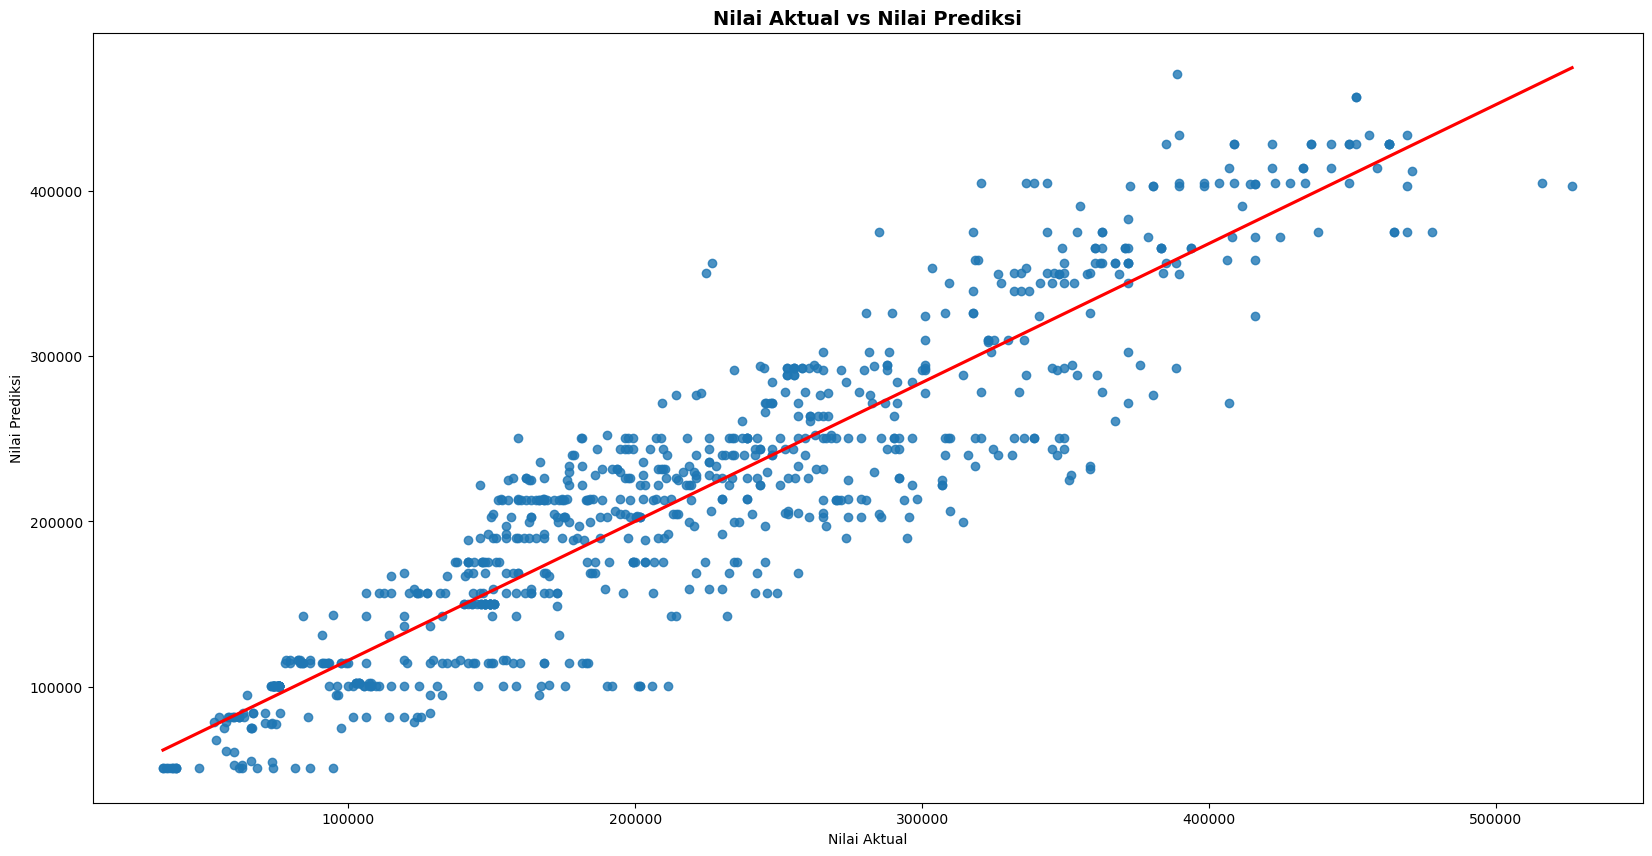

In [65]:
plt.figure(figsize=(20,10))
sns.regplot(x='y_aktual',
            y='y_prediksi', 
            data=resid,
            ci = None,
            line_kws={'color': 'r'})
plt.title('Nilai Aktual vs Nilai Prediksi', fontweight = 'bold', fontsize = 14)
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.show()

In [66]:
rekap_resid = cek_outlier(resid, resid.columns)[0]
rekap_resid['Proporsi(%)'] = rekap_resid['Jumlah Outlier']/len(df)*100

display(hasil_pred_tuning,
        rekap_resid)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331


,Kolom,Q1,Q3,IQR,Batas Atas,Batas Bawah,Jumlah Outlier,Proporsi(%)
2,residual,-25063.0,23591.0,48654.0,96572.0,-98044.0,26,0.630609
1,y_prediksi,149970.0,271928.0,121958.0,454865.0,-32967.0,3,0.072763
0,y_aktual,146902.0,287610.0,140708.0,498672.0,-64160.0,2,0.048508


Dari hasil visualisasi scatter plot antara nilai prediksi dan nilai aktual dapat dilihat bahwa masih terdapat bias yang terjadi, salah satu contohnya adalah pada harga apertemen > 500 ribu. Dimana model menghasilkan nilai prediksi apartemen < 500 ribu namun harga aktual dari apartemen tersebut di atas > 500 ribu. Meskipun masih terdapat bias namun pola dari sebaran data sudah membentuk pola regresi yang cukup jelas.

Berdasarkan metrik evaluasi regresi dapat diambil informasi bahwa model dapat memprediksi harga apartemen dengan error sebesar +- 31.572  won (MAE) atau error +- 16.7% (MAPE) dari harga aslinya. Nilai MAPE berkisar antara 10% - 20% sudah dapat dikatakan sebagai model yang bagus [(Stephen, 2022)](https://stephenallwright.com/good-mape-score/).

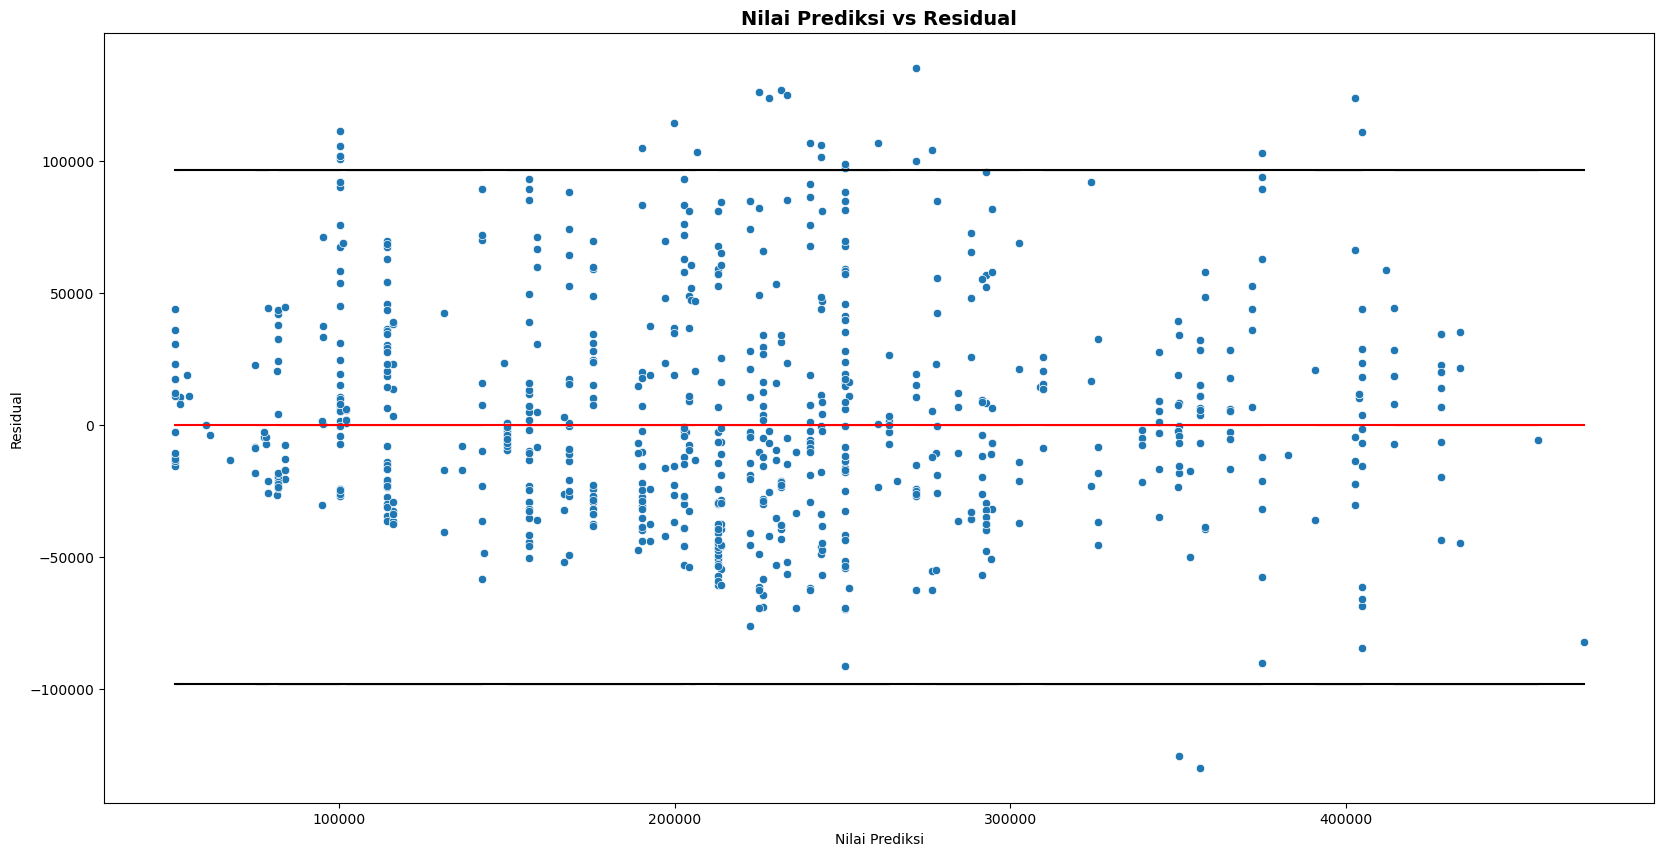

In [67]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='y_prediksi', y='residual', data=resid)
sns.lineplot(x='y_prediksi', y=0, data=resid, color='red')
sns.lineplot(x='y_prediksi', y=96572.0, data=resid, color='black') # batas atas residual
sns.lineplot(x='y_prediksi', y=-98044.0, data=resid, color='black') # batas bawah residual
plt.title('Nilai Prediksi vs Residual', fontweight = 'bold', fontsize = 14)
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residual')
plt.show()

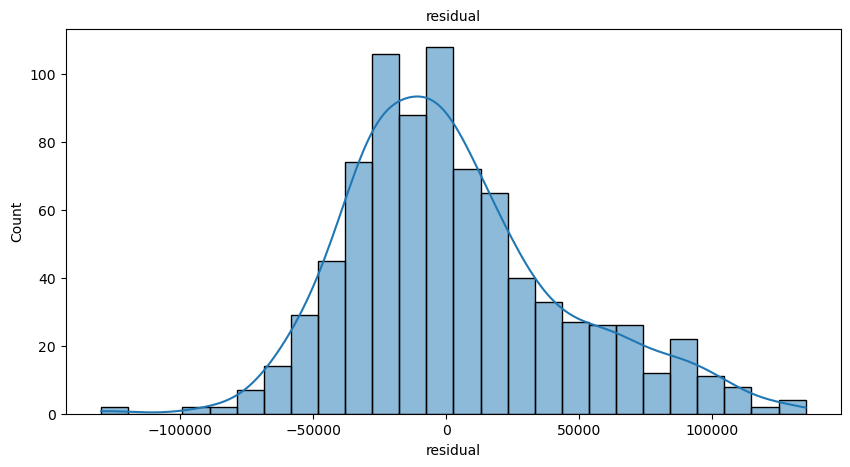

In [68]:
vis_hist(resid,'residual')

Dari hasil visualisasi nilai prediksi dan residual dapat dilihat bahwa:
- banyak data yang nilainya jatuh disekitar nilai 0, meskipun masih terdapat outlier pada residual (bias).
- eror tidak memiliki korelasi, hal tersebut dikarenakan tidak adanya pola yang terlihat pada scatter plot.
- berdasarkan histogram residual, sebaran datanya mendekati normal

## Feature Importances

<Axes: title={'center': 'Feature Importances'}>

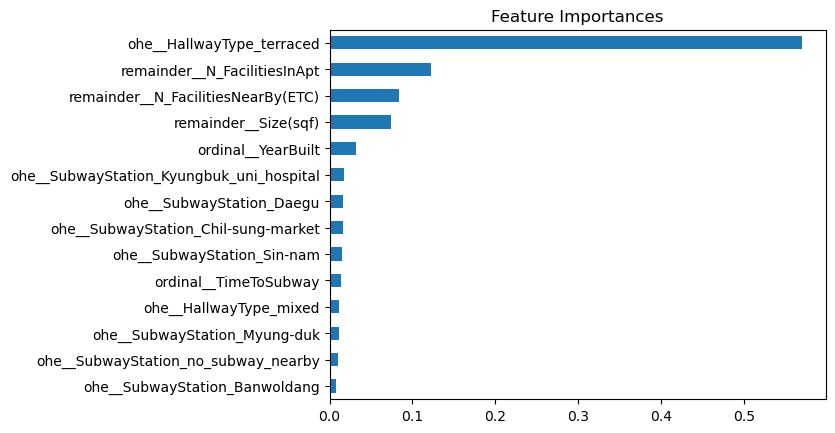

In [69]:
feature_imp = pd.Series(model_log_xgb_tuning.regressor_['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = True)
feature_imp.plot(kind='barh', title='Feature Importances')

# Kesimpulan & Rekomendasi

## Kesimpulan

- model terbaik adalah XGB Tuning with TTR, metrik yang digunakan adalah MAE, MAPE dan MSLE. MAE digunakan untuk menginterpretasikan model, MAPE digunakan untuk memperlihatkan akurasi model, MSLE digunakan untuk memilih model terbaik karena target variabel memiliki rentang yang besar dan memiliki right skewed distribution
- model tersebut menghasilkan nilai metrik sebagai berikut: 
    - MAE : 31572.332027
    - MAPE : 0.167993
    - MSLE : 0.046331
- dari metrik evaluasi dapat diambil informasi bahwa model dapat  memprediksi harga apartemen dengan error sebesar +- 31.572  won (MAE) atau error +- 16.7% (MAPE) dari harga aslinya. Namun masih ada kemungkian hasil prediksi model mengalami bias, hal tersebut dapat dilihat dari sebaran data nilai prediksi dan aktual serta nilai dari prediksi serta residual, hal itu dapat disebabkan karena adanya outlier harga apartemen yang masuk ke dalam data. Nilai MAPE berkisar antara 10% - 20% sudah dapat dikatakan sebagai model yang bagus [(Stephen, 2022)](https://stephenallwright.com/good-mape-score/).
- fitur yang sangat mempengaruhi harga apartemen adalah:
    - `HallwayType` khusunya jenis terraced
    - `N_FacilitiesInApt`
    - `N_FacilitiesNearBy(ETC)`
    - `Size(sqf)`
    - `YearBuilt`

- limitasi model berdasarkan statistika deskriptif, apabila menggunakan data diluar rentang nilai min max pada variabel numerik dan menggunakan data yang tidak terdapat pada data unique variabel kategorik hasil akan menjadi bias. 

In [70]:
display(df_prep.describe().loc[['min', 'max']],
        kategorik_unique.drop('Jumlah Data Unique', axis=1))

,N_FacilitiesNearBy(ETC),N_FacilitiesInApt,Size(sqf),SalePrice
min,0.0,1.0,135.0,32743.0
max,5.0,10.0,2337.0,585840.0


,Nama,Data Unique
0,HallwayType,"[corridor, mixed, terraced]"
1,TimeToSubway,"[0-5min, 10min~15min, 15min~20min, 5min~10min, no_bus_stop_nearby]"
2,SubwayStation,"[Bangoge, Banwoldang, Chil-sung-market, Daegu, Kyungbuk_uni_hospital, Myung-duk, Sin-nam, no_subway_nearby]"
3,YearBuilt,"[1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015]"


- limitasi model berdasarkan sebaran data residual dan prediksi:
    - gunakan nilai rentang fitur data yang mendapatkan harga prediksi apartemen < 200 ribu, kerena pada rentang tesebut outlier residual cenderung sedikit, sehingga hasil cenderung lebih baik

In [71]:
# mencari nilai rentang fitur yang mendapakan harga prediksi < 200 ribu
limit = X_test.copy()
limit['y test'] = y_test
limit['y pred'] = y_pred_tuning
limit['residual'] = y_test - y_pred_tuning
limit = limit[limit['y pred'] < 200000]

limit['YearBuilt'] = limit['YearBuilt'].astype('str')
object_col = limit.columns[limit.dtypes == object]

listItem = []
for col in limit[object_col].columns :
    listItem.append( [col, limit[col].nunique(), limit.sort_values(col)[col].unique()])

kategorik_unique = pd.DataFrame(columns=['Nama', 'Jumlah Data Unique', 'Data Unique'],
                     data=listItem)        

display(limit[['N_FacilitiesNearBy(ETC)','N_FacilitiesInApt','Size(sqf)']].describe().loc[['min', 'max']], 
        kategorik_unique)

,N_FacilitiesNearBy(ETC),N_FacilitiesInApt,Size(sqf)
min,0.0,1.0,135.0
max,5.0,9.0,1451.0


,Nama,Jumlah Data Unique,Data Unique
0,HallwayType,3,"[corridor, mixed, terraced]"
1,TimeToSubway,4,"[0-5min, 10min~15min, 15min~20min, 5min~10min]"
2,SubwayStation,8,"[Bangoge, Banwoldang, Chil-sung-market, Daegu, Kyungbuk_uni_hospital, Myung-duk, Sin-nam, no_subway_nearby]"
3,YearBuilt,12,"[1978, 1980, 1985, 1986, 1992, 1993, 1997, 2003, 2005, 2006, 2013, 2014]"


## Rekomendasi

**Model**

1. Mencari fitur atau karakteristik yang lebih dapat menggambarkan harga apartemen, hal tersebut dikarenakan banyak apartemen yang memiliki nilai fitur sama sehingga terindikasi sebagai data duplikat padahal data tersebut valid. Atau dapat dikatakan fitur kurang merepresentasikan harga apartemen dengan baik.
1. Melakukan pemodelan ulang berdasarkan temuan feature importance
1. Melakukan hyperparameter tuning kembali berdasarkan model feature importance dan membandingkan dengan hasil model ini
1. Mencari data apartemen yang memiliki nilai mahal (> batas atas IQR), sehingga tidak terjadi skewness pada variabel target
1. Melakukan update data apabila mendapatkan data harga apartemen baru

**Perusahaan**

1. Melakukan percobaan prediksi harga apartemen yang akan dibeli menggunakan model yang telah dibuat. Sehingga tidak mengeluarkan biaya untuk pihak ke-3.
<br>
Asumsi biaya untuk pihak ke-3 adalah 10 ribu won, sehingga apabila menggunakan model ada biaya yang terselamatkan sebesar 10 ribu won.
1. Menggunakan model sebagai bantuan dalam menetapkan harga jual apartemen, sehingga harga apartemen sesuai.

- simulasi saat harga overpriced

In [72]:
resid.iloc[1]

y_aktual      184955.0
y_prediksi    168524.0
residual       16431.0
Name: 1, dtype: float64

Dapat dilihat berdasakan hasil di atas, harga aktual apartemen adalah 184955 won namun dari hasil predikisi harga apartemen tersebut adalah 168524, hal tersebut mengindikasikan harga aktual tersebut overpriced berdasarkan dataset ini, sehingga terdapat potensi apartemen tersebut tidak laku, karena kalah saing dengan harga pasar yang ada.

- simulasi saat harga underpriced

In [73]:
resid.iloc[2]

y_aktual      70796.0
y_prediksi    78025.0
residual      -7229.0
Name: 2, dtype: float64

Dapat dilihat berdasakan hasil di atas, harga aktual apartemen adalah 70796 won namun dari hasil predikisi harga apartemen tersebut adalah 78025, hal tersebut mengidikasikan harga aktual tersebut underpriced berdasarkan dataset ini, sehingga keuntungan yang didapat tidak maksimal, terdapat loss sebesar 7229 won.

## Eksperimen menggunakan seluruh fitur

Decision tree dan algoritma boosted tree kebal terhadap multikolinearitas [(Will, 2019)](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4#:~:text=Multicollinearity%20happens%20when%20one%20predictor,immune%20to%20multicollinearity%20by%20nature%20.). Oleh karena itu karena sebelumnya hanya menggunakan fitur terpilih dari hasil pengecekan VIF. Kali ini pemodelan akan menggunakan keseluruhan fitur.

In [74]:
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [75]:
X2 = df.drop('SalePrice', axis=1)
y2 = df['SalePrice']

In [76]:
X2_trainval, X2_test, y2_trainval, y2_test = train_test_split(
    X2,
    y2,
    test_size=0.2,
    random_state=42
)

Pemodelan menggunakan model terpilih yaitu `XGB tuning with TTR`

In [77]:
grid_model_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType',
                                                   'SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
15min~20min           3
dtype: int64},
                                                                          {'col': 'YearBuilt',
                                                                           'data_type': dtype('O'),
                                                                           'mappin...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [78]:
model2_log_xgb_tuning = TransformedTargetRegressor(grid_model_tuning.best_estimator_,func=np.log, inverse_func=np.exp)

model2_log_xgb_tuning.fit(X2_trainval, y2_trainval)
y2_pred_tuning = model2_log_xgb_tuning.predict(X2_test)

hasil2_pred_tuning = pd.DataFrame()
hasil2_pred_tuning['Model'] = ['XGB  Tuning with TTR All Feature']
hasil2_pred_tuning['MAE'] = [mean_absolute_error(y2_test, y2_pred_tuning)]
hasil2_pred_tuning['MAPE'] = [mean_absolute_percentage_error(y2_test, y2_pred_tuning)]
hasil2_pred_tuning['MSLE'] = [mean_squared_log_error(y2_test, y2_pred_tuning)]

display(hasil2_pred_tuning, y2_pred_tuning)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR All Feature,31622.172448,0.168195,0.046464


array([293909.53 , 167475.45 ,  77548.99 , 405416.44 , 189979.72 ,
       189979.72 , 148751.62 , 215270.9  ,  76284.695, 225946.5  ,
       367606.3  , 100029.82 , 289095.25 , 214498.12 , 175577.73 ,
       251191.16 , 100029.82 , 236079.19 , 210800.98 , 396142.88 ,
        52179.547, 157369.   , 148751.62 , 225946.5  ,  82519.53 ,
       201907.84 , 309016.97 , 272158.03 , 346800.2  , 329508.53 ,
       235502.84 , 148751.62 , 100393.94 , 272158.03 , 346800.2  ,
        78525.62 , 274371.6  ,  82035.555, 251191.16 ,  93829.26 ,
       260619.69 , 148751.62 , 214498.12 , 338764.97 ,  81990.664,
       151949.56 , 100029.82 , 160991.23 , 222146.08 , 278398.56 ,
       157369.   , 230657.03 , 282029.1  , 113563.96 , 100393.94 ,
       241319.95 , 260619.69 , 346800.2  , 454628.12 , 222146.08 ,
       189979.72 , 293909.53 , 260619.69 , 260619.69 , 201907.84 ,
       157369.   , 113563.96 , 210800.98 , 292715.1  , 401999.53 ,
       167475.45 , 201907.84 , 175577.73 , 157369.   , 336149.

In [79]:
display(hasil2_pred_tuning,
        hasil_pred_tuning)

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR All Feature,31622.172448,0.168195,0.046464


,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331


Dapat dilihat bahwa model yang menggunakan seluruh fitur memiliki nilai metrik yang lebih tinggi dibanding yang tidak menggunakan seluruh fitur. Sehingga performansi model yang menggunakan seluruh fitur kurang baik

#  Deployment

In [80]:
import pickle

In [81]:
grid_model_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['HallwayType',
                                                   'SubwayStation']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': no_bus_stop_nearby    0
0-5min                1
10min~15min           2
15min~20min           3
dtype: int64},
                                                                          {'col': 'YearBuilt',
                                                                           'data_type': dtype('O'),
                                                                           'mappin...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [82]:
# # save model

# model = TransformedTargetRegressor(grid_model_tuning.best_estimator_,func=np.log, inverse_func=np.exp)
# model.fit(X_trainval, y_trainval)

# filename = 'Apartment Model.sav'
# pickle.dump(model, open(filename, 'wb')) # wb untuk nyimpan model # rb untuk memanggil model

In [83]:
# # load model
# filename = 'Apartment Model.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('ohe',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['HallwayType',
                                                                                        'SubwayStation']),
                                                                                      ('ordinal',
                                                                                       OrdinalEncoder(mapping=[{'col': 'TimeToSubway',
                                                                                                                'data_type': dtype('O'),
                                                                                                                'mapping': no_bus_stop_nearby    0
0-5min                1
10min...
                                                                   gpu_id=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.3,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=4,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=42, ...))]))

In [84]:
# print('MAE = {}'.format(mean_absolute_error(y_test, loaded_model.predict(X_test))))
# print('MAPE = {}'.format(mean_absolute_percentage_error(y_test, loaded_model.predict(X_test))))
# print('MSLE = {}'.format(mean_squared_log_error(y_test, loaded_model.predict(X_test))))

MAE = 31572.332026515152
MAPE = 0.16799268410318058
MSLE = 0.04633081172437795


In [85]:
# hasil_pred_tuning

,Model,MAE,MAPE,MSLE
0,XGB Tuning with TTR,31572.332027,0.167993,0.046331
